In [1]:
!pip install hopsworks pandas==2.1.4 numpy==1.26.4 matplotlib seaborn plotly scikit-learn

import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import userdata

os.environ["HOPSWORKS_API_KEY"] = userdata.get('HOPSWORKS_API_KEY')

In [3]:
from google.colab import userdata
import hopsworks

api_key = userdata.get('HOPSWORKS_API_KEY')
project = hopsworks.login(api_key_value=api_key)

fs = project.get_feature_store()
fg = fs.get_feature_group(name="karachi_raw_data_store", version=1)
existing_df = fg.read()



To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1238195
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


In [4]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [5]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 4.4 MB/s eta 0:00:00


In [6]:
%pip install xgboost

In [7]:
%pip install lightgbm statsmodels

In [8]:
!pip install shap

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import re
from typing import List, Tuple, Optional

warnings.filterwarnings('ignore')

def extract_max_window_from_features(feature_names: List[str]) -> int:
    max_window = 0
    window_pattern = r'(\d+)h'

    for feature in feature_names:
        matches = re.findall(window_pattern, feature)
        for match in matches:
            window_size = int(match)
            max_window = max(max_window, window_size)

    return max_window

def smart_drop_initial_rows(df: pd.DataFrame,
                           feature_columns: Optional[List[str]] = None,
                           min_drop_hours: int = 0) -> Tuple[pd.DataFrame, int]:

    if df.empty:
        print("Warning: Empty dataframe provided.")
        return df, 0

    if feature_columns is None:
        feature_columns = df.columns.tolist()

    max_window = extract_max_window_from_features(feature_columns)

    rows_to_drop = max(max_window, min_drop_hours)

    if rows_to_drop == 0:
        print("No rows need to be dropped.")
        return df, 0

    initial_shape = df.shape

    if rows_to_drop >= len(df):
        print(f"Warning: Trying to drop {rows_to_drop} rows but dataframe only has {len(df)} rows.")
        print("Dropping all but the last row to preserve structure.")
        rows_to_drop = len(df) - 1

    df_processed = df.iloc[rows_to_drop:].copy()

    print(f"\nRow dropping summary:")
    print(f"  Initial shape: {initial_shape}")
    print(f"  Rows dropped: {rows_to_drop}")
    print(f"  Final shape: {df_processed.shape}")
    print(f"  Data retained: {len(df_processed)/len(df)*100:.1f}%")

    return df_processed, rows_to_drop

class AQIDataPreprocessor:

    def __init__(self, file_path=None, dataframe=None):
        self.file_path = file_path
        self.df = dataframe
        self.processed_df = None
        self.feature_columns = []
        self.target_column = 'aqi'
        self.pollutant_columns = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3']
        self.weather_columns = ['temperature', 'humidity', 'wind_speed', 'wind_direction']
        self.removed_features = {
            'high_correlation': [],
            'low_variance': [],
            'high_vif': []
        }
        self.label_encoders = {}
        self.original_numeric_features = []
        self.target_schema_columns = None

    def load_data(self, file_path=None, dataframe=None):
        """Load the dataset from a file or use a provided DataFrame."""
        print("\n" + "="*50)
        print("LOADING DATA")
        print("="*50)

        if dataframe is not None:
            self.df = dataframe.copy()
            print("Using provided DataFrame.")
        elif file_path:
            self.file_path = file_path
            try:
                self.df = pd.read_csv(self.file_path)
                print(f"Data loaded successfully from {self.file_path}! Shape: {self.df.shape}")
            except FileNotFoundError:
                print(f"Error loading data: File not found at {self.file_path}")
                return False
            except Exception as e:
                print(f"Error loading data: {e}")
                return False
        else:
            print("No file path or DataFrame provided. Creating sample data structure...")
            self.create_sample_data()

        if self.df is not None:
             self.df.columns = self.df.columns.str.lower().str.replace('.', '_', regex=False)
             self.df.rename(columns={
                 'pm2_5': 'pm2_5',
                 'pm10': 'pm10',
                 'co': 'co',
                 'so2': 'so2',
                 'o3': 'o3',
                 'no2': 'no2',
                 'aqi': 'aqi'
             }, inplace=True)

             self.inspect_data()
             return True
        else:
             return False

    def inspect_data(self):
        """Inspect the loaded dataset"""
        print("\n" + "="*50)
        print("DATA INSPECTION")
        print("="*50)

        if self.df is None:
            print("No data available for inspection.")
            return

        print(f"Dataset shape: {self.df.shape}")
        print(f"Memory usage: {self.df.memory_usage().sum() / 1024**2:.2f} MB")

        print("\nColumn data types:")
        print(self.df.dtypes)

        print("\nMissing values:")
        missing = self.df.isnull().sum()
        print(missing[missing > 0])

        print("\nBasic statistics:")
        print(self.df.describe())

        self.datetime_column = None
        for col in self.df.columns:
            if 'date' in col.lower() or 'time' in col.lower():
                try:
                    pd.to_datetime(self.df[col])
                    self.datetime_column = col
                    break
                except:
                    pass

        if self.datetime_column:
            print(f"\nDatetime column identified: {self.datetime_column}")
            print(f"Date range: {self.df[self.datetime_column].min()} to {self.df[self.datetime_column].max()}")
        else:
            print("\nNo suitable datetime column found.")

        self.target_column = None
        for col in self.df.columns:
            if 'aqi' in col.lower():
                self.target_column = col
                break

        if self.target_column:
            print(f"Target column: {self.target_column}")
        else:
            print("Warning: No target column ('aqi' or similar) found.")

        self.original_numeric_features = [col for col in self.df.select_dtypes(include=np.number).columns if col != self.datetime_column and col != self.target_column]
        print(f"\nIdentified original numeric features: {self.original_numeric_features}")


    def clean_data(self):
        print("\n" + "="*50)
        print("DATA CLEANING")
        print("="*50)

        if self.df is None:
            print("No data available to clean. Load data first.")
            return

        self.processed_df = self.df.copy()

        if self.datetime_column and self.datetime_column in self.processed_df.columns:
            print(f"Processing datetime column: {self.datetime_column}")
            self.processed_df[self.datetime_column] = pd.to_datetime(self.processed_df[self.datetime_column])
            self.processed_df = self.processed_df.sort_values(self.datetime_column)
            self.processed_df.set_index(self.datetime_column, inplace=True)
            if self.datetime_column in self.processed_df.columns:
                 self.processed_df = self.processed_df.drop(columns=[self.datetime_column])
                 print(f"Dropped original datetime column '{self.datetime_column}'.")
        else:
             print("No suitable datetime column found or specified. Skipping datetime index setting.")
             if not isinstance(self.processed_df.index, pd.DatetimeIndex):
                  print("Creating a default DatetimeIndex for time series operations.")
                  try:
                       self.processed_df.index = pd.date_range(start='2025-04-21', periods=len(self.processed_df), freq='H')
                       print("Default DatetimeIndex created.")
                  except Exception as e:
                       print(f"Could not create a default DatetimeIndex: {e}. Some time-series features might fail.")

        initial_shape = self.processed_df.shape
        self.processed_df = self.processed_df.drop_duplicates()
        print(f"Removed {initial_shape[0] - self.processed_df.shape[0]} duplicate rows")

        print("\nHandling missing values...")
        self.handle_missing_values()

        print("\nRemoving outliers...")
        self.remove_outliers()

        print("\nOptimizing data types...")
        self.optimize_data_types()

        print(f"\nCleaned data shape: {self.processed_df.shape}")

    def handle_missing_values(self):
        """Handle missing values using various strategies"""
        missing_before = self.processed_df.isnull().sum().sum()

        if isinstance(self.processed_df.index, pd.DatetimeIndex):
            for col in self.processed_df.columns:
                if self.processed_df[col].isnull().any():
                    self.processed_df[col] = self.processed_df[col].fillna(method='ffill', limit=2)

            numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if self.processed_df[col].isnull().any():
                    self.processed_df[col] = self.processed_df[col].interpolate(method='time', limit=6)
        else:
            print("Skipping time-based fillna and interpolate as index is not DatetimeIndex.")

        if self.processed_df.isnull().any().any():
            print("Applying KNN imputation for remaining missing values...")
            numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns

            if len(numeric_cols) > 0:
                imputer = KNNImputer(n_neighbors=5)
                self.processed_df[numeric_cols] = imputer.fit_transform(self.processed_df[numeric_cols])

        categorical_cols = self.processed_df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if self.processed_df[col].isnull().any():
                mode_value = self.processed_df[col].mode()
                if len(mode_value) > 0:
                    self.processed_df[col] = self.processed_df[col].fillna(mode_value[0])

        missing_after = self.processed_df.isnull().sum().sum()
        print(f"Missing values: {missing_before} -> {missing_after}")

    def remove_outliers(self):
        print("Replacing outliers with NaN using IQR and then backfilling...")
        numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns
        outliers_replaced = 0

        for col in numeric_cols:
            if col == self.target_column:
                Q1 = self.processed_df[col].quantile(0.05)
                Q3 = self.processed_df[col].quantile(0.95)
            else:
                Q1 = self.processed_df[col].quantile(0.25)
                Q3 = self.processed_df[col].quantile(0.75)

            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR

            outliers = (self.processed_df[col] < lower_bound) | (self.processed_df[col] > upper_bound)
            outliers_count = outliers.sum()

            if outliers_count > 0:
                print(f"  {col}: {outliers_count} outliers replaced with NaN")
                self.processed_df.loc[outliers, col] = np.nan
                outliers_replaced += outliers_count

        print(f"Total outliers replaced with NaN: {outliers_replaced}")

        if isinstance(self.processed_df.index, pd.DatetimeIndex):
             print("Backfilling NaN values after outlier replacement...")
             self.processed_df.fillna(method='bfill', inplace=True)
             self.processed_df.fillna(method='ffill', inplace=True)
             print("Backfilling and forward filling completed.")
        else:
             print("Skipping backfilling as index is not DatetimeIndex.")


    def optimize_data_types(self):
        for col in self.processed_df.columns:
            if self.processed_df[col].dtype == 'float64':
                self.processed_df[col] = self.processed_df[col].astype('float32')
            elif self.processed_df[col].dtype == 'int64':
                self.processed_df[col] = self.processed_df[col].astype('int32')

    def create_time_features(self):
        print("\n" + "="*50)
        print("CREATING TIME FEATURES")
        print("="*50)

        if not isinstance(self.processed_df.index, pd.DatetimeIndex):
            print("Skipping time feature creation as index is not a DatetimeIndex.")
            return

        self.processed_df['hour'] = self.processed_df.index.hour
        self.processed_df['day_of_week'] = self.processed_df.index.dayofweek
        self.processed_df['day'] = self.processed_df.index.day
        self.processed_df['weekday'] = self.processed_df.index.dayofweek
        self.processed_df['month'] = self.processed_df.index.month
        self.processed_df['is_weekend'] = (self.processed_df.index.dayofweek >= 5).astype(int)

        self.processed_df['season'] = self.processed_df['month'] % 12 // 3 + 1

        self.processed_df['hour_sin'] = np.sin(2 * np.pi * self.processed_df['hour'] / 24)
        self.processed_df['hour_cos'] = np.cos(2 * np.pi * self.processed_df['hour'] / 24)

        self.processed_df['day_sin'] = np.sin(2 * np.pi * self.processed_df['day_of_week'] / 7)
        self.processed_df['day_cos'] = np.cos(2 * np.pi * self.processed_df['day_of_week'] / 7)

        print(f"Created time features")

    def create_future_targets(self, horizons=[24, 48, 72]):
        """Create future target variables for multi-step forecasting."""
        print("\n" + "="*50)
        print("CREATING FUTURE TARGETS")
        print("="*50)
        if self.target_column and self.target_column in self.processed_df.columns:
            for h in horizons:
                self.processed_df[f'aqi_{h}h'] = self.processed_df[self.target_column].shift(-h)
            print(f"Created future targets for horizons: {horizons}")
        else:
            print("Target column not found. Skipping future target creation.")

    def create_lag_features(self, min_lag=72):
        print("\n" + "="*50)
        print(f"CREATING LAG FEATURES (min_lag={min_lag}h)")
        print("="*50)

        if not isinstance(self.processed_df.index, pd.DatetimeIndex):
             print("Skipping lag feature creation as index is not a DatetimeIndex.")
             return

        lag_periods = [min_lag, min_lag + 12, min_lag + 24, min_lag + 48, min_lag + 72, min_lag + 96]

        if self.target_column and self.target_column in self.processed_df.columns:
             for lag in lag_periods:
                  self.processed_df[f'{self.target_column}_lag_{lag}h'] = self.processed_df[self.target_column].shift(lag)
        else:
             print(f"Warning: Target column '{self.target_column}' not found. Skipping target lag features.")

        # Create lag features for pollutants
        for pollutant in self.pollutant_columns:
            if pollutant in self.processed_df.columns:
                for lag in lag_periods:
                    self.processed_df[f'{pollutant}_lag_{lag}h'] = self.processed_df[pollutant].shift(lag)

        print(f"Created lag features with periods: {lag_periods}")

    def create_rolling_features(self, min_lag=72):
        print("\n" + "="*50)
        print(f"CREATING ROLLING FEATURES (min_lag={min_lag}h)")
        print("="*50)

        if not isinstance(self.processed_df.index, pd.DatetimeIndex):
             print("Skipping rolling feature creation as index is not a DatetimeIndex.")
             return

        if self.target_column and self.target_column in self.processed_df.columns:
            aqi_rolling_windows = [24, 48, 72]
            for window in aqi_rolling_windows:
                # Create rolling features on a series that is already lagged by min_lag
                lagged_aqi = self.processed_df[self.target_column].shift(min_lag)
                self.processed_df[f'{self.target_column}_rolling_std_{window}h_lag{min_lag}h'] = lagged_aqi.rolling(window=window).std()
                self.processed_df[f'{self.target_column}_rolling_max_{window}h_lag{min_lag}h'] = lagged_aqi.rolling(window=window).max()

        pollutant_rolling = {
            'pm10': [24],
            'pm2_5': [24],
            'co': [24, 48],
            'no2': [24, 48],
            'so2': [24, 48],
            'o3': [24, 48]
        }

        for pollutant, windows in pollutant_rolling.items():
            if pollutant in self.processed_df.columns:
                for window in windows:
                    lagged_pollutant = self.processed_df[pollutant].shift(min_lag)
                    self.processed_df[f'{pollutant}_rolling_std_{window}h_lag{min_lag}h'] = lagged_pollutant.rolling(window=window).std()

        print(f"Created rolling features on data lagged by {min_lag}h")


    def create_interaction_features(self):
        """Create interaction features between important variables"""
        print("\n" + "="*50)
        print("CREATING INTERACTION FEATURES")
        print("="*50)

        # Temperature and humidity interaction (heat index proxy)
        if 'temperature' in self.processed_df.columns and 'humidity' in self.processed_df.columns:
            self.processed_df['temp_humidity_interaction'] = (
                self.processed_df['temperature'] * self.processed_df['humidity'] / 100
            )

        # Wind speed and direction features
        if 'wind_speed' in self.processed_df.columns and 'wind_direction' in self.processed_df.columns:
            self.processed_df['wind_u'] = (
                self.processed_df['wind_speed'] * np.cos(np.radians(self.processed_df['wind_direction']))
            )
            self.processed_df['wind_v'] = (
                self.processed_df['wind_speed'] * np.sin(np.radians(self.processed_df['wind_direction']))
            )

        if 'pm2_5' in self.processed_df.columns and 'pm10' in self.processed_df.columns:
             self.processed_df['pm25_pm10_ratio'] = (
                self.processed_df['pm2_5'] / (self.processed_df['pm10'] + 1e-6)
             )

        print("Created interaction features")

    def create_statistical_features(self, min_lag=72):
        print("\n" + "="*50)
        print(f"CREATING STATISTICAL FEATURES (min_lag={min_lag}h)")
        print("="*50)

        if self.target_column and self.target_column in self.processed_df.columns:
            rate_changes = [24, 48, 72]
            for hours in rate_changes:
                feature_name = f'{self.target_column}_rate_change_{hours}h_lag{min_lag}h'
                self.processed_df[feature_name] = self.processed_df[self.target_column].shift(min_lag).diff(hours)

            print("Created statistical features for target column on lagged data.")
        else:
            print(f"Warning: Target column '{self.target_column}' not found. Skipping statistical features for target column.")


    def remove_low_variance_features(self, threshold=1e-6):
         print("\n" + "="*50)
         print("REMOVING LOW VARIANCE FEATURES")
         print("="*50)

         if self.processed_df is None or self.processed_df.empty:
             print("No data to remove low variance features from.")
             return

         numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns
         features_to_drop = []

         for col in numeric_cols:
             variance = self.processed_df[col].var(skipna=True)
             if pd.isna(variance) or variance < threshold:
                 features_to_drop.append(col)
                 self.removed_features['low_variance'].append(col)
                 print(f"  Removing '{col}' due to low variance ({variance:.6f})")

         if features_to_drop:
             self.processed_df = self.processed_df.drop(columns=features_to_drop)
             print(f"Removed {len(features_to_drop)} low variance features.")
         else:
             print("No low variance features found to remove.")


    def reduce_multicollinearity(self, correlation_threshold=0.85):

        print("\n" + "="*50)
        print("REDUCING MULTICOLLINEARITY (Correlation)")
        print("="*50)

        if self.processed_df is None or self.processed_df.empty:
            print("No data to reduce multicollinearity from.")
            return []

        numeric_df = self.processed_df.select_dtypes(include=[np.number]).copy()
        if self.target_column in numeric_df.columns:
            features_for_corr = numeric_df.drop(columns=[self.target_column])
        else:
             features_for_corr = numeric_df

        corr_matrix = features_for_corr.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        features_to_drop_corr = set()
        for column in upper.columns:
            highly_correlated_cols = upper.index[upper[column] > correlation_threshold].tolist()

            if highly_correlated_cols:
                for corr_col in highly_correlated_cols:
                    if column not in features_to_drop_corr:
                        features_to_drop_corr.add(column)
                        self.removed_features['high_correlation'].append(column)

        if features_to_drop_corr:
            self.processed_df = self.processed_df.drop(columns=list(features_to_drop_corr), errors='ignore')
            print(f"Removed {len(features_to_drop_corr)} features due to high multicollinearity.")
        else:
            print("No features found with multicollinearity above the threshold to remove.")

        self.feature_columns = [col for col in self.processed_df.columns if col != self.target_column]

        return self.feature_columns

    def encode_categorical_features(self):

        print("\n" + "="*50)
        print("ENCODING CATEGORICAL FEATURES")
        print("="*50)

        categorical_cols = self.processed_df.select_dtypes(include=['object']).columns

        for col in categorical_cols:
            if col != self.target_column:
                le = LabelEncoder()
                self.processed_df[col] = le.fit_transform(self.processed_df[col].astype(str))
                self.label_encoders[col] = le
                print(f"Encoded {col}: {len(le.classes_)} unique categories")

    def enhanced_finalize_dataset(self):

      print("\n" + "="*50)
      print("SMART FINALIZING DATASET")
      print("="*50)
      future_target_cols = [f'aqi_{h}h' for h in [24, 48, 72]]
      self.processed_df.dropna(subset=future_target_cols, inplace=True)

      print("\nApplying smart row dropping based on maximum lag/rolling window...")

      all_columns = self.processed_df.columns.tolist()
      if self.processed_df.index.name:
        all_columns.append(self.processed_df.index.name)

      initial_rows = len(self.processed_df)
      self.processed_df, rows_dropped = smart_drop_initial_rows(
        self.processed_df,
        feature_columns=all_columns,
        min_drop_hours=0
      )

      print(f"Smart dropping removed {rows_dropped} initial rows (instead of all NaN rows)")

      remaining_nans_before = self.processed_df.isnull().sum().sum()
      if remaining_nans_before > 0:
        print(f"\nHandling {remaining_nans_before} remaining NaN values in the dataset...")

        numeric_cols = self.processed_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if self.processed_df[col].isnull().any():
                self.processed_df[col] = self.processed_df[col].interpolate(
                    method='linear', limit_direction='both'
                )

        self.processed_df = self.processed_df.fillna(method='ffill')

        self.processed_df = self.processed_df.fillna(method='bfill')

        remaining_nans_after = self.processed_df.isnull().sum().sum()
        print(f"NaN values after interpolation and filling: {remaining_nans_after}")

        if remaining_nans_after > 0:
            print("Dropping columns with remaining unfillable NaN values...")
            cols_before_drop = set(self.processed_df.columns)
            self.processed_df = self.processed_df.dropna(axis=1)
            cols_after_drop = set(self.processed_df.columns)
            dropped_cols = cols_before_drop - cols_after_drop
            print(f"Columns dropped due to unfillable NaNs: {list(dropped_cols)}")

      self.feature_columns = [col for col in self.processed_df.columns if col != self.target_column and 'aqi_' not in col]

      print("\nFinal check for low variance features...")
      self.remove_low_variance_features()
      self.feature_columns = [col for col in self.processed_df.columns if col != self.target_column and 'aqi_' not in col]


      print(f"\nFinal dataset shape after smart processing: {self.processed_df.shape}")
      print(f"Final feature count: {len(self.feature_columns)}")
      print(f"Target column: {self.target_column}")
      print(f"Data retention: {len(self.processed_df)/initial_rows*100:.1f}% of original rows")


    def get_feature_importance_analysis(self):
        print("\n" + "="*50)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*50)

        if not self.feature_columns:
            print("No features available for analysis")
            return None

        if self.target_column not in self.processed_df.columns:
             print(f"Target column '{self.target_column}' not found in processed data. Skipping feature importance analysis.")
             return None

        correlations = []
        analysis_df = self.processed_df[self.feature_columns + [self.target_column]]

        for feature in self.feature_columns:
            if pd.api.types.is_numeric_dtype(analysis_df[feature]):
                 try:
                    if analysis_df[feature].var(skipna=True) > 1e-9:
                        corr = analysis_df[feature].corr(analysis_df[self.target_column])
                        correlations.append((feature, abs(corr)))
                    else:
                         correlations.append((feature, 0))
                 except Exception as e:
                    print(f"Could not calculate correlation for feature '{feature}': {e}")
                    correlations.append((feature, 0))

        correlations.sort(key=lambda x: x[1], reverse=True)

        print("Top 20 features by correlation with target:")
        meaningful_correlations = [(f, c) for f, c in correlations if c > 0]
        for i, (feature, corr) in enumerate(meaningful_correlations[:20]):
            print(f"{i+1:2d}. {feature:<40}: {corr:.4f}")

        if not meaningful_correlations:
            print("No features with non-zero correlation found.")

        return correlations


    def generate_preprocessing_report(self):
        """Generate a comprehensive preprocessing report"""
        print("\n" + "="*80)
        print("PREPROCESSING REPORT")
        print("="*80)

        if self.df is not None:
             print(f"Original dataset shape: {self.df.shape}")
        else:
             print("Original dataset not loaded.")

        print(f"Processed dataset shape: {self.processed_df.shape}")
        print(f"Target column: {self.target_column}")
        print(f"Final feature count: {len(self.feature_columns)}")

        print(f"\nFeatures removed during preprocessing steps:")
        print(f"  Removed due to low variance: {len(self.removed_features['low_variance'])}")
        print(f"  Removed due to high correlation: {len(self.removed_features['high_correlation'])}")

        print(f"\nData quality:")
        print(f"  Missing values: {self.processed_df.isnull().sum().sum()}")
        print(f"  Duplicate rows: {self.processed_df.duplicated().sum()}")

        print(f"\nMemory usage: {self.processed_df.memory_usage().sum() / 1024**2:.2f} MB")


    def run_full_preprocessing(self, correlation_threshold=0.85, variance_threshold=1e-6, vif_threshold=10, dataframe=None, target_schema_columns=None, forecast_horizon=72):
        print("="*80)
        print("STARTING FULL PREPROCESSING PIPELINE")
        print("="*80)

        if not self.load_data(dataframe=dataframe):
            return False

        self.clean_data()

        self.create_future_targets(horizons=[24, 48, 72])

        self.create_time_features()
        self.create_lag_features(min_lag=forecast_horizon)
        self.create_rolling_features(min_lag=forecast_horizon)
        self.create_interaction_features()
        self.create_statistical_features(min_lag=forecast_horizon)

        self.feature_columns = self.reduce_multicollinearity(
            correlation_threshold=correlation_threshold
        )
        self.encode_categorical_features()

        self.enhanced_finalize_dataset()

        if self.target_column and self.target_column in self.processed_df.columns:
             self.get_feature_importance_analysis()
        else:
             print("\nSkipping feature importance analysis as target column is not in final features.")

        self.generate_preprocessing_report()

        print("\n" + "="*80)
        print("PREPROCESSING COMPLETED SUCCESSFULLY!")
        print("="*80)

        return True


    def get_processed_data(self):
        """Return the processed dataset"""
        if self.processed_df is not None:
            y_data = None
            if self.target_column and self.target_column in self.processed_df.columns:
                 y_data = self.processed_df[[f'aqi_{h}h' for h in [24, 48, 72]]]
                 X_features = [col for col in self.feature_columns if col != self.target_column and 'aqi_' not in col]
            else:
                 X_features = self.feature_columns
                 if self.target_column:
                    print(f"Warning: Target column '{self.target_column}' not found in processed data after filtering.")


            valid_X_features = [col for col in X_features if col in self.processed_df.columns]
            invalid_X_features = [col for col in X_features if col not in self.processed_df.columns]

            if invalid_X_features:
                 print(f"Warning: The following features listed to keep were not found after preprocessing and filtering: {invalid_X_features}")


            return {
                'X': self.processed_df[valid_X_features],
                'y': y_data,
                'feature_names': valid_X_features,
                'target_name': self.target_column,
                'full_data': self.processed_df
            }
        else:
            print("No processed data available. Run preprocessing first.")
            return None

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import pickle
import joblib
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class AQIForecastingSystem:

    def __init__(self, horizon_df, target_column, horizon_hours, model_save_path="./aqi_models"):
        self.df = horizon_df.copy()
        self.target_column = target_column
        self.horizon_hours = horizon_hours
        self.model_save_path = model_save_path

        if 'event_time' in self.df.columns:
            self.df['event_time'] = pd.to_datetime(self.df['event_time'])
            self.df = self.df.sort_values('event_time').reset_index(drop=True)

        self.models = {}
        self.ensemble_models = {}
        self.selected_features = []
        self.results = {}
        self.predictions = {}
        self.ensemble_predictions = {}

        os.makedirs(self.model_save_path, exist_ok=True)

        print(f" Initialized for {horizon_hours}h horizon")
        print(f" Dataset shape: {self.df.shape}")
        print(f" Target column: {target_column}")
        print(f" Model save path: {self.model_save_path}")

    def validate_data_quality(self):
        """Validate data quality for the specific horizon"""
        print(f" Validating data quality for {self.horizon_hours}h horizon...")

        issues = []

        if self.target_column not in self.df.columns:
            issues.append(f"Target column '{self.target_column}' not found in dataframe")
            return issues

        target_data = self.df[self.target_column].dropna()
        if len(target_data) == 0:
            issues.append(f"{self.target_column} has no valid data")
            return issues

        target_std = target_data.std()
        target_mean = target_data.mean()

        print(f"   {self.target_column}: mean={target_mean:.2f}, std={target_std:.2f}, count={len(target_data)}")

        if target_std < 1:
            issues.append(f"{self.target_column} has very low variance ({target_std:.3f})")

        if (target_data < 0).any():
            issues.append(f"{self.target_column} has {(target_data < 0).sum()} negative values")

        if target_data.max() > 500:
            issues.append(f"{self.target_column} has suspiciously high values (max: {target_data.max():.1f})")

        feature_cols = [col for col in self.df.columns if col not in [self.target_column, 'event_time', 'date', 'unique_id', 'aqi']]
        print(f"   Available features: {len(feature_cols)}")

        if len(feature_cols) == 0:
            issues.append("No feature columns found")

        high_missing_features = []
        for col in feature_cols:
            missing_pct = self.df[col].isna().sum() / len(self.df)
            if missing_pct > 0.8:
                high_missing_features.append((col, missing_pct))

        if high_missing_features:
            issues.append(f"{len(high_missing_features)} features have >80% missing values")

        if issues:
            print(" Data quality issues found:")
            for issue in issues:
                print(f"   • {issue}")
        else:
            print("Data quality checks passed")

        return issues

    def handle_outliers(self, data, method='iqr', cap_percentile=0.01):
        print(" Handling outliers in features...")

        data_cleaned = data.copy()
        outlier_counts = {}

        for col in data_cleaned.select_dtypes(include=[np.number]).columns:
            if col == self.target_column:
                continue

            original_values = data_cleaned[col].dropna()

            if len(original_values) == 0:
                continue

            if method == 'iqr':
                Q1 = original_values.quantile(0.25)
                Q3 = original_values.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outlier_mask = (data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)
                outlier_count = outlier_mask.sum()

                data_cleaned[col] = data_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

            elif method == 'winsorize':
                lower_percentile = cap_percentile
                upper_percentile = 1 - cap_percentile

                lower_bound = original_values.quantile(lower_percentile)
                upper_bound = original_values.quantile(upper_percentile)

                outlier_mask = (data_cleaned[col] < lower_bound) | (data_cleaned[col] > upper_bound)
                outlier_count = outlier_mask.sum()

                data_cleaned[col] = data_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

            if outlier_count > 0:
                outlier_counts[col] = outlier_count

        if outlier_counts:
            print(f"   Handled outliers in {len(outlier_counts)} features")
            top_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"   Top outlier features: {top_outliers}")

        return data_cleaned

    def mutual_info_feature_selection(self, X, y, k=15):
        """Select features using mutual information"""
        selector = SelectKBest(score_func=mutual_info_regression, k=min(k, X.shape[1]))
        X_selected = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()].tolist()
        scores = selector.scores_[selector.get_support()]

        return selected_features, scores

    def rf_importance_feature_selection(self, X, y, k=15):
        """Select features using Random Forest importance"""
        rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X, y)

        importances = rf.feature_importances_
        feature_importance_pairs = list(zip(X.columns, importances))
        feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

        selected_features = [pair[0] for pair in feature_importance_pairs[:k]]
        selected_scores = [pair[1] for pair in feature_importance_pairs[:k]]

        return selected_features, selected_scores

    def cross_validated_feature_selection(self, X, y, n_splits=3, max_features=15):
        print(f"    Hybrid feature selection for {self.horizon_hours}h horizon...")

        tscv = TimeSeriesSplit(n_splits=n_splits)
        mi_score_total = {}
        rf_score_total = {}
        fold_counts = {}

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train = X.iloc[train_idx].fillna(X.median())
            y_train = y.iloc[train_idx]

            try:
                mi_features, mi_scores = self.mutual_info_feature_selection(X_train, y_train, k=max_features)
                for feat, score in zip(mi_features, mi_scores):
                    mi_score_total[feat] = mi_score_total.get(feat, 0) + score
                    fold_counts[feat] = fold_counts.get(feat, 0) + 1
            except Exception as e:
                print(f"      MI selection failed in fold {fold}: {e}")

            try:
                rf_features, rf_scores = self.rf_importance_feature_selection(X_train, y_train, k=max_features)
                for feat, score in zip(rf_features, rf_scores):
                    rf_score_total[feat] = rf_score_total.get(feat, 0) + score
                    fold_counts[feat] = fold_counts.get(feat, 0) + 1
            except Exception as e:
                print(f"      RF selection failed in fold {fold}: {e}")

        all_features = set(mi_score_total.keys()) | set(rf_score_total.keys())
        hybrid_scores = {}
        for feat in all_features:
            mi = mi_score_total.get(feat, 0)
            rf = rf_score_total.get(feat, 0)
            mi_norm = mi / n_splits
            rf_norm = rf / n_splits
            hybrid_scores[feat] = (mi_norm + rf_norm) / 2

        sorted_features = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
        final_features = [f for f, _ in sorted_features[:max_features]]

        print(f"      Selected {len(final_features)} features")
        print(f"      Top 5 features: {final_features[:5]}")

        return final_features, {
            'hybrid_scores': hybrid_scores,
            'fold_counts': fold_counts
        }

    def feature_selection_pipeline(self, max_features=15):
        """Complete feature selection pipeline for the specific horizon"""
        print(f" Starting feature selection for {self.horizon_hours}h horizon...")

        exclude_cols = [self.target_column, "date", "event_time", "unique_id"]
        all_features = [col for col in self.df.columns if col not in exclude_cols]

        if not all_features:
            print(f" No features found for selection")
            self.selected_features = []
            return {}

        print(f"   Initial features: {len(all_features)}")

        filtered_features = []
        for feature in all_features:
            missing_pct = self.df[feature].isna().sum() / len(self.df)
            if missing_pct < 0.5:
                filtered_features.append(feature)

        print(f"   After missing value filter: {len(filtered_features)} features")

        if not filtered_features:
            print(f" No features passed missing value filter")
            self.selected_features = []
            return {}

        low_var_threshold = 1e-6
        variance_filtered_features = []

        for feature in filtered_features:
            if pd.api.types.is_numeric_dtype(self.df[feature]):
                feature_var = self.df[feature].var()
                if feature_var > low_var_threshold:
                    variance_filtered_features.append(feature)
            else:
                variance_filtered_features.append(feature)

        print(f"   After variance filter: {len(variance_filtered_features)} features")

        if not variance_filtered_features:
            print(f" No features passed variance filter")
            self.selected_features = []
            return {}

        # Step 3: Handle outliers
        feature_data = self.df[variance_filtered_features + [self.target_column]].copy()
        feature_data_clean = self.handle_outliers(feature_data[variance_filtered_features])
        feature_data[variance_filtered_features] = feature_data_clean

        numeric_features = feature_data[variance_filtered_features].select_dtypes(include=[np.number]).columns.tolist()

        if len(numeric_features) > 1:
            corr_data = feature_data[numeric_features].fillna(method='ffill').fillna(method='bfill')
            corr_matrix = corr_data.corr().abs()

            upper_triangle = corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
            )

            high_corr_features = []
            for col in upper_triangle.columns:
                high_corr_cols = upper_triangle[col][upper_triangle[col] > 0.85].index.tolist()
                if high_corr_cols:
                    target_corrs = feature_data[numeric_features + [self.target_column]].corr()[self.target_column].abs()
                    for corr_col in high_corr_cols:
                        if target_corrs[col] >= target_corrs[corr_col]:
                            if corr_col not in high_corr_features:
                                high_corr_features.append(corr_col)
                        else:
                            if col not in high_corr_features:
                                high_corr_features.append(col)

            correlation_filtered_features = [f for f in variance_filtered_features if f not in high_corr_features]
            print(f"   After correlation filter: {len(correlation_filtered_features)} features (removed {len(high_corr_features)})")
        else:
            correlation_filtered_features = variance_filtered_features

        if not correlation_filtered_features:
            print(f" No features passed correlation filter")
            self.selected_features = []
            return {}

        X_features = feature_data[correlation_filtered_features]
        y_target = feature_data[self.target_column]

        valid_rows = ~y_target.isna()
        X_features = X_features[valid_rows]
        y_target = y_target[valid_rows]

        if len(X_features) < 100:
            print(f" Insufficient clean data: {len(X_features)} rows")
            self.selected_features = []
            return {}

        try:
            selected_features, selection_details = self.cross_validated_feature_selection(
                X_features, y_target, max_features=max_features
            )

            self.selected_features = selected_features

            feature_selection_details = {
                'initial_features': len(all_features),
                'after_missing_filter': len(filtered_features),
                'after_variance_filter': len(variance_filtered_features),
                'after_correlation_filter': len(correlation_filtered_features),
                'final_selected': len(selected_features),
                'selection_details': selection_details,
                'selected_features': selected_features
            }

            print(f"    Final selected features: {len(selected_features)}")
            if selected_features:
                print(f"    Top 5 features: {selected_features[:5]}")

            return feature_selection_details

        except Exception as e:
            print(f" Error in feature selection: {e}")
            self.selected_features = []
            return {}

    def check_data_leakage(self):
        """Check for data leakage in selected features"""
        print(" Checking for data leakage...")

        if not self.selected_features:
            print("   No features selected to check")
            return {}

        target_data = self.df[self.selected_features + [self.target_column]].dropna()
        if len(target_data) == 0:
            print(f"     No clean data for correlation analysis")
            return {}

        correlations = target_data[self.selected_features].corrwith(target_data[self.target_column]).abs()
        high_corr_features = correlations[correlations > 0.85].index.tolist()

        suspicious_features = []
        for feature in self.selected_features:
            feature_lower = feature.lower()
            if any(suspicious in feature_lower for suspicious in ['future', 'ahead', 'target']):
                suspicious_features.append(feature)

        leakage_results = {
            'high_correlation_features': high_corr_features,
            'suspicious_name_features': suspicious_features,
            'max_correlation': correlations.max() if not correlations.empty else 0,
            'mean_correlation': correlations.mean() if not correlations.empty else 0
        }

        if high_corr_features or suspicious_features:
            print(f"      Potential leakage detected:")
            if high_corr_features:
                print(f"       High correlation (>0.95): {high_corr_features}")
            if suspicious_features:
                print(f"       Suspicious names: {suspicious_features}")
        else:
            print(f"      No obvious leakage detected")
            print(f"       Max correlation: {correlations.max():.3f}")

        return leakage_results

    def initialize_models(self):
        """Initialize all tree-based models"""
        print(" Initializing tree-based models...")

        self.model_configs = {
            'CatBoost': CatBoostRegressor(
                iterations=672,
                learning_rate=0.018212208878911028,
                depth=7,
                l2_leaf_reg=1.8344212761367933,
                early_stopping_rounds=50,
                verbose=False,
                subsample=0.6076978090537759,
                random_seed=42,
            ),
            'XGBoost': XGBRegressor(
                n_estimators=738,
                learning_rate=0.050902082752918125,
                max_depth=6,
                reg_alpha=3.623661367173843,
                reg_lambda=2.3632955886312637,
                early_stopping_rounds=50,
                random_state=42,
                subsample=0.728994202987864,
                colsample_bytree=0.7490071788934142,
                verbosity=0
            ),
            'LightGBM': LGBMRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                min_child_samples=20,
                reg_alpha=0.1,
                reg_lambda=0.1,
                early_stopping_rounds=50,
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.8,
                verbosity=-1
            ),
            'RandomForest': RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1
            ),
            'ExtraTrees': ExtraTreesRegressor(
                n_estimators=251,
                max_depth=9,
                min_samples_split=10,
                min_samples_leaf=20,
                random_state=42,
                n_jobs=-1,
                max_features=0.6449383229836702
            ),
            'GradientBoosting': GradientBoostingRegressor(
                n_estimators=115,
                learning_rate=0.1436659003499937,
                max_depth=3,
                min_samples_split=7,
                min_samples_leaf=2,
                random_state=42
            ),
            'DecisionTree': DecisionTreeRegressor(
                max_depth=15,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42
            )
        }

        self.ensemble_configs = {
            'Ensemble_CBX_ET': ['CatBoost', 'XGBoost', 'ExtraTrees']
        }

    def create_ensemble_predictions(self, fold_predictions):
        """Create ensemble predictions by averaging specified models"""
        ensemble_preds = {}

        for ensemble_name, model_list in self.ensemble_configs.items():
            model_preds = []
            for model_name in model_list:
                if model_name in fold_predictions:
                    model_preds.append(fold_predictions[model_name])

            if len(model_preds) > 0:
                ensemble_pred = np.mean(model_preds, axis=0)
                ensemble_preds[ensemble_name] = ensemble_pred

        return ensemble_preds

    def calculate_metrics(self, y_true, y_pred):
        try:
            if len(y_true) == 0 or len(y_pred) == 0:
                return {
                    'rmse': np.inf, 'mae': np.inf, 'r2': -np.inf,
                    'mse': np.inf, 'mape': np.inf, 'std': 0, 'mean': 0
                }

            y_true = np.array(y_true)
            y_pred = np.array(y_pred)

            valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
            if not valid_mask.any():
                return {
                    'rmse': np.inf, 'mae': np.inf, 'r2': -np.inf,
                    'mse': np.inf, 'mape': np.inf, 'std': 0, 'mean': 0
                }

            y_true_clean = y_true[valid_mask]
            y_pred_clean = y_pred[valid_mask]

            mse = mean_squared_error(y_true_clean, y_pred_clean)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true_clean, y_pred_clean)
            r2 = r2_score(y_true_clean, y_pred_clean)

            mape_mask = y_true_clean != 0
            if mape_mask.any():
                mape = np.mean(np.abs((y_true_clean[mape_mask] - y_pred_clean[mape_mask]) / y_true_clean[mape_mask])) * 100
            else:
                mape = np.inf

            return {
                'rmse': float(rmse), 'mae': float(mae), 'r2': float(r2),
                'mse': float(mse), 'mape': float(mape),
                'std': float(np.std(y_pred_clean)), 'mean': float(np.mean(y_pred_clean))
            }

        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            return {
                'rmse': np.inf, 'mae': np.inf, 'r2': -np.inf,
                'mse': np.inf, 'mape': np.inf, 'std': 0, 'mean': 0
            }

    def sliding_window_validation(self, train_size=8*7*24, test_size=4*7*24, step_size=2*24):
        print(f" Starting sliding window validation for {self.horizon_hours}h horizon...")
        print(f" Parameters: train_size={train_size}, test_size={test_size}, step_size={step_size}")

        if not self.selected_features:
            print(" No features selected! Run feature selection first.")
            return

        valid_features = [f for f in self.selected_features if f in self.df.columns]
        if not valid_features:
            print(" No valid selected features found in dataframe")
            return

        total_samples = len(self.df)
        print(f" Total samples: {total_samples}, Using {len(valid_features)} features")

        windows = []
        train_start = 0

        while train_start + train_size + test_size <= total_samples:
            train_end = train_start + train_size
            test_start = train_end
            test_end = min(test_start + test_size, total_samples)

            windows.append({
                'train_start': train_start,
                'train_end': train_end,
                'test_start': test_start,
                'test_end': test_end
            })

            train_start += step_size

        if not windows:
            print(" Not enough data for sliding window validation!")
            print(f" Required: {train_size + test_size} samples, Available: {total_samples}")
            return

        print(f" Created {len(windows)} sliding windows")

        self.results = {model_name: [] for model_name in self.model_configs.keys()}
        self.predictions = {model_name: [] for model_name in self.model_configs.keys()}

        ensemble_names = list(self.ensemble_configs.keys())
        self.ensemble_results = {ensemble_name: [] for ensemble_name in ensemble_names}
        self.ensemble_predictions = {ensemble_name: [] for ensemble_name in ensemble_names}

        self.final_models = {model_name: None for model_name in self.model_configs.keys()}

        for fold, window in enumerate(windows):
            train_start, train_end, test_start, test_end = window['train_start'], window['train_end'], window['test_start'], window['test_end']

            print(f"Window {fold + 1}/{len(windows)}: Train[{train_start}:{train_end}] ({train_end-train_start} samples), Test[{test_start}:{test_end}] ({test_end-test_start} samples)")

            try:
                df_clean = self.df[valid_features + [self.target_column]].copy()
                df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

                X_train = df_clean.iloc[train_start:train_end][valid_features]
                X_test = df_clean.iloc[test_start:test_end][valid_features]
                y_train = df_clean.iloc[train_start:train_end][self.target_column]
                y_test = df_clean.iloc[test_start:test_end][self.target_column]

                fold_predictions = {}

                for model_name, model_config in self.model_configs.items():
                    try:
                        if model_name in ['CatBoost', 'XGBoost', 'LightGBM']:
                            model = model_config.__class__(**model_config.get_params())

                            if len(X_train) > 100:
                                val_size = max(int(0.15 * len(X_train)), 50)
                                X_val, y_val = X_train.iloc[-val_size:], y_train.iloc[-val_size:]
                                X_train_sub, y_train_sub = X_train.iloc[:-val_size], y_train.iloc[:-val_size]

                                if model_name == 'CatBoost':
                                    model.fit(X_train_sub, y_train_sub, eval_set=(X_val, y_val))
                                elif model_name == 'XGBoost':
                                    model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)])
                                else:
                                    model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)])
                            else:
                                model.fit(X_train, y_train)
                        else:
                            model = model_config.__class__(**model_config.get_params())
                            model.fit(X_train, y_train)

                        train_pred = model.predict(X_train)
                        test_pred = model.predict(X_test)

                        fold_predictions[model_name] = test_pred

                        train_metrics = self.calculate_metrics(y_train, train_pred)
                        test_metrics = self.calculate_metrics(y_test, test_pred)

                        fold_result = {
                            'fold': fold,
                            'window': window,
                            'train_size': len(X_train),
                            'test_size': len(X_test),
                            'train_metrics': train_metrics,
                            'test_metrics': test_metrics,
                            'train_pred': train_pred,
                            'test_pred': test_pred,
                            'y_train': y_train.values,
                            'y_test': y_test.values,
                        }

                        self.results[model_name].append(fold_result)
                        self.predictions[model_name].extend(test_pred)

                        if fold == len(windows) - 1:
                            self.final_models[model_name] = model

                    except Exception as e:
                        print(f"    Error training {model_name} in fold {fold}: {str(e)}")
                        continue

                ensemble_preds = self.create_ensemble_predictions(fold_predictions)

                for ensemble_name, ensemble_pred in ensemble_preds.items():
                    try:
                        ensemble_metrics = self.calculate_metrics(y_test, ensemble_pred)

                        ensemble_fold_result = {
                            'fold': fold,
                            'window': window,
                            'train_size': len(X_train),
                            'test_size': len(X_test),
                            'test_metrics': ensemble_metrics,
                            'test_pred': ensemble_pred,
                            'y_test': y_test.values,
                            'component_models': self.ensemble_configs[ensemble_name],
                        }

                        self.ensemble_results[ensemble_name].append(ensemble_fold_result)
                        self.ensemble_predictions[ensemble_name].extend(ensemble_pred)

                    except Exception as e:
                        print(f"    Error creating ensemble {ensemble_name} in fold {fold}: {str(e)}")
                        continue

            except Exception as e:
                print(f"    Error processing fold {fold}: {str(e)}")
                continue

        print(f" Completed {len(windows)} windows of sliding validation")

    def train_final_models(self):
        print(f" Training final models for {self.horizon_hours}h horizon...")

        if not self.selected_features:
            print(" No features selected! Run feature selection first.")
            return

        valid_features = [f for f in self.selected_features if f in self.df.columns]
        if not valid_features:
            print(" No valid selected features found in dataframe")
            return

        self.deployment_models = {model_name: None for model_name in self.model_configs.keys()}

        try:
            df_clean = self.df[valid_features + [self.target_column]].copy()
            df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')

            X_full = df_clean[valid_features]
            y_full = df_clean[self.target_column]

            for model_name, model_config in self.model_configs.items():
                try:
                    model = model_config.__class__(**model_config.get_params())

                    if model_name in ['CatBoost', 'XGBoost', 'LightGBM']:
                        val_size = max(int(0.2 * len(X_full)), 100)
                        X_val, y_val = X_full.iloc[-val_size:], y_full.iloc[-val_size:]
                        X_train_sub, y_train_sub = X_full.iloc[:-val_size], y_full.iloc[:-val_size]

                        if model_name == 'CatBoost':
                            model.fit(X_train_sub, y_train_sub, eval_set=(X_val, y_val))
                        elif model_name == 'XGBoost':
                            model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)])
                        else:
                            model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)])
                    else:
                        model.fit(X_full, y_full)

                    self.deployment_models[model_name] = model

                    print(f"    {model_name} trained ({len(valid_features)} features)")

                except Exception as e:
                    print(f"    Error training final {model_name}: {str(e)}")
                    continue

        except Exception as e:
            print(f"    Error preparing data: {str(e)}")

        print(" Final model training completed")

    def save_models(self, save_metadata=True):
        """Save all trained models and metadata"""
        print("Saving models and metadata...")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        save_dir = os.path.join(self.model_save_path, f"aqi_models_{self.horizon_hours}h_{timestamp}")
        os.makedirs(save_dir, exist_ok=True)

        models_dir = os.path.join(save_dir, "individual_models")
        os.makedirs(models_dir, exist_ok=True)

        for model_name in self.model_configs.keys():
            if model_name in self.deployment_models and self.deployment_models[model_name] is not None:
                model = self.deployment_models[model_name]
                model_dir = os.path.join(models_dir, model_name)
                os.makedirs(model_dir, exist_ok=True)

                try:
                    if model_name == 'CatBoost':
                        model.save_model(os.path.join(model_dir, f"{model_name}_{self.horizon_hours}h.cbm"))
                    elif model_name == 'XGBoost':
                        joblib.dump(model, os.path.join(model_dir, f"{model_name}_{self.horizon_hours}h.joblib"))
                    elif model_name == 'LightGBM':
                        joblib.dump(model, os.path.join(model_dir, f"{model_name}_{self.horizon_hours}h.joblib"))
                    else:
                        joblib.dump(model, os.path.join(model_dir, f"{model_name}_{self.horizon_hours}h.pkl"))

                    print(f"    Saved {model_name}")

                except Exception as e:
                    print(f"    Error saving {model_name}: {str(e)}")

        ensemble_dir = os.path.join(save_dir, "ensemble_models")
        os.makedirs(ensemble_dir, exist_ok=True)

        ensemble_metadata = {
            'ensemble_configs': self.ensemble_configs,
            'component_models': list(self.model_configs.keys()),
            'horizon_hours': self.horizon_hours,
            'ensemble_method': 'simple_average'
        }

        with open(os.path.join(ensemble_dir, "ensemble_config.json"), 'w') as f:
            json.dump(ensemble_metadata, f, indent=2)

        if save_metadata:
            metadata = {
                'selected_features': self.selected_features,
                'target_column': self.target_column,
                'horizon_hours': self.horizon_hours,
                'model_configs': {name: str(config.get_params()) for name, config in self.model_configs.items()},
                'ensemble_configs': self.ensemble_configs,
                'dataset_shape': self.df.shape,
                'training_timestamp': timestamp,
            }

            with open(os.path.join(save_dir, "metadata.json"), 'w') as f:
                json.dump(metadata, f, indent=2)
        with open(os.path.join(save_dir, "selected_features.json"), 'w') as f:
            json.dump(self.selected_features, f, indent=2)

        print(f" All models and metadata saved to: {save_dir}")
        return save_dir

    def load_models(self, model_dir):
        print(f" Loading models from: {model_dir}")

        metadata_path = os.path.join(model_dir, "metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            self.selected_features = metadata.get('selected_features', [])
            self.target_column = metadata.get('target_column', '')
            self.horizon_hours = metadata.get('horizon_hours', 0)
            print(f"    Loaded metadata for {self.horizon_hours}h horizon")

        features_path = os.path.join(model_dir, "selected_features.json")
        if os.path.exists(features_path):
            with open(features_path, 'r') as f:
                self.selected_features = json.load(f)

        models_dir = os.path.join(model_dir, "individual_models")
        self.loaded_models = {}

        for model_name in ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest',
                          'ExtraTrees', 'GradientBoosting', 'DecisionTree']:
            model_path = os.path.join(models_dir, model_name)
            if os.path.exists(model_path):
                try:
                    if model_name == 'CatBoost':
                        model_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.cbm")
                        if os.path.exists(model_file):
                            model = CatBoostRegressor()
                            model.load_model(model_file)
                            self.loaded_models[model_name] = model
                    elif model_name == 'XGBoost':
                        joblib_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.joblib")
                        json_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.json")

                        if os.path.exists(joblib_file):
                            model = joblib.load(joblib_file)
                        elif os.path.exists(json_file):
                            model = XGBRegressor()
                            model.load_model(json_file)
                        else:
                            raise FileNotFoundError(f"XGBoost model not found at {joblib_file} or {json_file}")

                        self.loaded_models[model_name] = model

                    elif model_name == 'LightGBM':
                        joblib_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.joblib")
                        txt_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.txt")

                        import lightgbm as lgb

                        if os.path.exists(joblib_file):
                            model = joblib.load(joblib_file)
                        elif os.path.exists(txt_file):
                            model = lgb.Booster(model_file=txt_file)
                        else:
                            raise FileNotFoundError(f"LightGBM model not found at {joblib_file} or {txt_file}")

                        self.loaded_models[model_name] = model

                    else:
                        model_file = os.path.join(model_path, f"{model_name}_{self.horizon_hours}h.pkl")
                        if os.path.exists(model_file):
                            model = joblib.load(model_file)
                            self.loaded_models[model_name] = model

                    if model_name in self.loaded_models:
                        print(f"    Loaded {model_name}")

                except Exception as e:
                    print(f"    Error loading {model_name}: {str(e)}")

        ensemble_config_path = os.path.join(model_dir, "ensemble_models", "ensemble_config.json")
        if os.path.exists(ensemble_config_path):
            with open(ensemble_config_path, 'r') as f:
                ensemble_data = json.load(f)
            self.ensemble_configs = ensemble_data['ensemble_configs']
            print(f"   Loaded ensemble configurations")

        print("Model loading completed")

    def predict_with_ensemble(self, X):
        """Make predictions using individual models and ensembles"""
        if not hasattr(self, 'loaded_models'):
            print("No models loaded. Please load models first using load_models()")
            return None

        if not self.selected_features:
            print("No selected features loaded. Please load models first using load_models()")
            return None

        predictions = {}

        for model_name, model in self.loaded_models.items():
            try:
                if isinstance(X, pd.DataFrame):
                    available_features = [f for f in self.selected_features if f in X.columns]
                    if len(available_features) != len(self.selected_features):
                        missing_features = set(self.selected_features) - set(available_features)
                        print(f"Warning: Missing features for {model_name}: {missing_features}")
                        if not available_features:
                            continue
                    X_model = X[self.selected_features]
                else:
                    X_model = X

                if model_name == 'LightGBM' and hasattr(model, 'predict'):
                    pred = model.predict(X_model)
                else:
                    pred = model.predict(X_model)

                predictions[model_name] = pred

            except Exception as e:
                print(f"Error predicting with {model_name}: {str(e)}")
                continue

        ensemble_predictions = {}
        for ensemble_name, model_list in self.ensemble_configs.items():
            model_preds = []

            for model_name in model_list:
                if model_name in predictions:
                    model_preds.append(predictions[model_name])

            if len(model_preds) > 0:
                ensemble_pred = np.mean(model_preds, axis=0)
                ensemble_predictions[ensemble_name] = ensemble_pred

        all_predictions = {**predictions, **ensemble_predictions}

        return all_predictions

    def evaluate_generalization(self):
        print(f"Evaluating generalization for {self.horizon_hours}h horizon...")

        evaluation_results = {}

        for model_name in self.model_configs.keys():
            if not self.predictions.get(model_name):
                continue

            preds = np.array(self.predictions[model_name])

            std_pred = np.std(preds)

            fold_results = self.results.get(model_name, [])
            if fold_results:
                train_rmse_list = [fold['train_metrics']['rmse'] for fold in fold_results]
                test_rmse_list = [fold['test_metrics']['rmse'] for fold in fold_results]
                train_mae_list = [fold['train_metrics']['mae'] for fold in fold_results]
                test_mae_list = [fold['test_metrics']['mae'] for fold in fold_results]
                train_r2_list = [fold['train_metrics']['r2'] for fold in fold_results]
                test_r2_list = [fold['test_metrics']['r2'] for fold in fold_results]
                train_mse_list = [fold['train_metrics']['mse'] for fold in fold_results]
                test_mse_list = [fold['test_metrics']['mse'] for fold in fold_results]
                train_mape_list = [fold['train_metrics']['mape'] for fold in fold_results]
                test_mape_list = [fold['test_metrics']['mape'] for fold in fold_results]

                avg_train_rmse = np.mean(train_rmse_list)
                avg_test_rmse = np.mean(test_rmse_list)
                avg_train_mae = np.mean(train_mae_list)
                avg_test_mae = np.mean(test_mae_list)
                avg_train_r2 = np.mean(train_r2_list)
                avg_test_r2 = np.mean(test_r2_list)
                avg_train_mse = np.mean(train_mse_list)
                avg_test_mse = np.mean(test_mse_list)
                avg_train_mape = np.mean(train_mape_list)
                avg_test_mape = np.mean(test_mape_list)

                train_sizes = [fold['train_size'] for fold in fold_results]
                avg_train_size = np.mean(train_sizes)
                final_train_size = train_sizes[-1] if train_sizes else 0
            else:
                avg_train_rmse = avg_test_rmse = avg_train_r2 = avg_test_r2 = 0
                avg_train_mae = avg_test_mae = avg_train_mse = avg_test_mse = 0
                avg_train_mape = avg_test_mape = 0
                avg_train_size = final_train_size = 0

            std_check = std_pred > 3
            feature_count = len(self.selected_features)

            evaluation_results[model_name] = {
                'std_pred': std_pred,
                'avg_train_rmse': avg_train_rmse,
                'avg_test_rmse': avg_test_rmse,
                'avg_train_r2': avg_train_r2,
                'avg_test_r2': avg_test_r2,
                'avg_train_mse': avg_train_mse,
                'avg_test_mse': avg_test_mse,
                'avg_train_mae': avg_train_mae,
                'avg_test_mae': avg_test_mae,
                'avg_train_mape': avg_train_mape,
                'avg_test_mape': avg_test_mape,
                'avg_train_size': avg_train_size,
                'final_train_size': final_train_size,
                'feature_count': feature_count,
                'std_check_passed': std_check,
                'prediction_quality': 'Good' if std_check else 'Poor'
            }
        if hasattr(self, 'ensemble_predictions'):
            for ensemble_name in self.ensemble_predictions.keys():
                if not self.ensemble_predictions.get(ensemble_name):
                    continue

                preds = np.array(self.ensemble_predictions[ensemble_name])
                std_pred = np.std(preds)
                fold_results = self.ensemble_results.get(ensemble_name, [])
                if fold_results:
                    test_rmse_list = [fold['test_metrics']['rmse'] for fold in fold_results]
                    test_r2_list = [fold['test_metrics']['r2'] for fold in fold_results]
                    test_mae_list = [fold['test_metrics']['mae'] for fold in fold_results]
                    test_mse_list = [fold['test_metrics']['mse'] for fold in fold_results]
                    test_mape_list = [fold['test_metrics']['mape'] for fold in fold_results]

                    avg_test_rmse = np.mean(test_rmse_list)
                    avg_test_r2 = np.mean(test_r2_list)
                    avg_test_mae = np.mean(test_mae_list)
                    avg_test_mse = np.mean(test_mse_list)
                    avg_test_mape = np.mean(test_mape_list)

                    train_sizes = [fold['train_size'] for fold in fold_results]
                    avg_train_size = np.mean(train_sizes)
                    final_train_size = train_sizes[-1] if train_sizes else 0
                else:
                    avg_test_rmse = avg_test_r2 = avg_test_mae = avg_test_mse = avg_test_mape = 0
                    avg_train_size = final_train_size = 0

                std_check = std_pred > 3
                feature_count = len(self.selected_features)

                evaluation_results[ensemble_name] = {
                    'std_pred': std_pred,
                    'avg_test_rmse': avg_test_rmse,
                    'avg_test_r2': avg_test_r2,
                    'avg_test_mae': avg_test_mae,
                    'avg_test_mse': avg_test_mse,
                    'avg_test_mape': avg_test_mape,
                    'avg_train_size': avg_train_size,
                    'final_train_size': final_train_size,
                    'feature_count': feature_count,
                    'std_check_passed': std_check,
                    'prediction_quality': 'Good' if std_check else 'Poor',
                    'component_models': self.ensemble_configs[ensemble_name]
                }

        return evaluation_results

    def generate_report(self):
        """Generate comprehensive performance report"""
        print(" Generating performance report...")

        evaluation_results = self.evaluate_generalization()

        print("\n" + "="*80)
        print(f"AQI FORECASTING SYSTEM PERFORMANCE REPORT - {self.horizon_hours}H HORIZON")
        print("="*80)

        print(f"\n Configuration:")
        print(f"   Forecast horizon: {self.horizon_hours} hours")
        print(f"   Target column: {self.target_column}")
        print(f"   Selected features: {len(self.selected_features)}")
        print(f"   Individual models: {len(self.model_configs)}")
        print(f"   Ensemble models: {len(self.ensemble_configs)}")
        print(f"   Validation method: Sliding Window")
        print(f"   Dataset shape: {self.df.shape}")

        print(f"\nQuality Checks:")
        print(f"  Standard deviation > 3 (prevents flat predictions)")
        print(f"  Sliding window validation (no future leakage)")
        print(f"  Cross-validated feature selection")

        print(f"\nIndividual Model Performance:")
        print("-" * 80)

        for model_name in self.model_configs.keys():
            if model_name not in evaluation_results:
                continue

            results = evaluation_results[model_name]

            print(f"\n {model_name}:")
            print(f"    Train Metrics:")
            print(f"       MSE  = {results.get('avg_train_mse', 0):.3f}")
            print(f"       RMSE = {results.get('avg_train_rmse', 0):.3f}")
            print(f"       MAE  = {results.get('avg_train_mae', 0):.3f}")
            print(f"       MAPE = {results.get('avg_train_mape', 0):.2f}%")
            print(f"       R²   = {results.get('avg_train_r2', 0):.3f}")

            print(f"   Test Metrics:")
            print(f"       MSE  = {results.get('avg_test_mse', 0):.3f}")
            print(f"       RMSE = {results.get('avg_test_rmse', 0):.3f}")
            print(f"       MAE  = {results.get('avg_test_mae', 0):.3f}")
            print(f"       MAPE = {results.get('avg_test_mape', 0):.2f}%")
            print(f"       R²   = {results.get('avg_test_r2', 0):.3f}")
            print(f"       STD  = {results.get('std_pred', 0):.3f}")
            print(f"       Quality = {results.get('prediction_quality', 'N/A')}")

        if hasattr(self, 'ensemble_results'):
            print(f"\n🔗 Ensemble Model Performance:")
            print("-" * 80)

            for ensemble_name in self.ensemble_configs.keys():
                if ensemble_name not in evaluation_results:
                    continue

                results = evaluation_results[ensemble_name]

                print(f"\n {ensemble_name} (Components: {', '.join(self.ensemble_configs[ensemble_name])}):")
                print(f"   MSE={results.get('avg_test_mse', 0):.3f}, "
                      f"RMSE={results.get('avg_test_rmse', 0):.3f}, "
                      f"MAE={results.get('avg_test_mae', 0):.3f}, "
                      f"MAPE={results.get('avg_test_mape', 0):.2f}%, "
                      f"R²={results.get('avg_test_r2', 0):.3f}, "
                      f"STD={results.get('std_pred', 0):.3f}, "
                      f"Quality={results.get('prediction_quality', 'N/A')}")

        print(f"\nBest Performing Model:")
        print("-" * 80)

        best_r2 = -999
        best_model = None

        for model_name, model_results in evaluation_results.items():
            r2 = model_results.get('avg_test_r2', -999)
            if r2 > best_r2:
                best_r2 = r2
                best_model = model_name

        if best_model:
            model_type = " Ensemble" if best_model in self.ensemble_configs else " Individual"
            print(f"   {model_type} - {best_model} (R²={best_r2:.3f})")

        # Feature summary
        if self.selected_features:
            print(f"\n Selected Features ({len(self.selected_features)}):")
            print("-" * 80)
            print(f"   {', '.join(self.selected_features[:10])}{'...' if len(self.selected_features) > 10 else ''}")

        print("\n" + "="*80)
        print(f" SYSTEM VALIDATION COMPLETE - {self.horizon_hours}H HORIZON")
        print("="*80)

        return evaluation_results

    def train_baseline(self):
        from sklearn.linear_model import LinearRegression
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.metrics import r2_score, mean_squared_error

        print(f" Training baseline models for {self.horizon_hours}h horizon...")

        if not self.selected_features:
            print(" No features selected! Run feature selection first.")
            return {}

        available_features = [f for f in self.selected_features if f in self.df.columns]
        if not available_features:
            print(" No valid feature columns found")
            return {}

        print(f"   Using {len(available_features)} features")

        all_cols = available_features + [self.target_column]
        clean_data = self.df[all_cols].dropna()

        if len(clean_data) < 100:
            print(f" Insufficient clean data! Only {len(clean_data)} rows available")
            return {}

        print(f"   Clean data shape: {clean_data.shape}")

        split_idx = int(0.8 * len(clean_data))

        X_train = clean_data[available_features].iloc[:split_idx]
        X_test = clean_data[available_features].iloc[split_idx:]
        y_train = clean_data[self.target_column].iloc[:split_idx]
        y_test = clean_data[self.target_column].iloc[split_idx:]

        results = {}

        try:
            lr = LinearRegression()
            lr.fit(X_train, y_train)

            lr_pred = lr.predict(X_test)
            lr_r2 = r2_score(y_test, lr_pred)
            lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

            print(f"   Linear Regression: R²={lr_r2:.4f}, RMSE={lr_rmse:.3f}")
            results['linear_r2'] = lr_r2
            results['linear_rmse'] = lr_rmse
        except Exception as e:
            print(f"   Linear Regression failed: {e}")
            results['linear_r2'] = -999
            results['linear_rmse'] = 999

        try:
            rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
            rf.fit(X_train, y_train)

            rf_pred = rf.predict(X_test)
            rf_r2 = r2_score(y_test, rf_pred)
            rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

            print(f"   Random Forest: R²={rf_r2:.4f}, RMSE={rf_rmse:.3f}")
            results['rf_r2'] = rf_r2
            results['rf_rmse'] = rf_rmse

            if hasattr(rf, 'feature_importances_'):
                feature_imp = list(zip(available_features, rf.feature_importances_))
                feature_imp.sort(key=lambda x: x[1], reverse=True)
                top_features = feature_imp[:3]
                print(f"   Top 3 important features: {[(f, round(imp, 3)) for f, imp in top_features]}")

        except Exception as e:
            print(f"   Random Forest failed: {e}")
            results['rf_r2'] = -999
            results['rf_rmse'] = 999

        naive_pred = np.full(len(y_test), y_train.mean())
        naive_r2 = r2_score(y_test, naive_pred)
        naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))

        print(f"   Naive (mean): R²={naive_r2:.4f}, RMSE={naive_rmse:.3f}")
        print(f"   Target stats: mean={y_test.mean():.2f}, std={y_test.std():.2f}")

        results.update({
            'naive_r2': naive_r2,
            'naive_rmse': naive_rmse,
            'target_std': y_test.std(),
            'target_mean': y_test.mean(),
            'test_size': len(y_test),
            'train_size': len(y_train)
        })

        print(f"   Baseline evaluation completed for {self.horizon_hours}h horizon")
        return results

    def run_complete_pipeline(self, max_features=15, train_baseline=True, save_models=True):

      print(f"\n Starting complete AQI forecasting pipeline for {self.horizon_hours}h horizon")
      print("="*80)

      pipeline_results = {
        'horizon_hours': self.horizon_hours,
        'target_column': self.target_column,
        'dataset_shape': self.df.shape,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
      }

      print("\nData Quality Validation")
      quality_issues = self.validate_data_quality()
      pipeline_results['data_quality_issues'] = quality_issues

      if quality_issues:
        print(" Data quality issues found - proceeding with caution")

      print("\n Feature Selection Pipeline")
      feature_selection_results = self.feature_selection_pipeline(max_features=max_features)
      pipeline_results['feature_selection'] = feature_selection_results

      if not self.selected_features:
         print("Feature selection failed - cannot proceed")
         return pipeline_results

      print("\n Data Leakage Detection")
      leakage_results = self.check_data_leakage()
      pipeline_results['leakage_check'] = leakage_results

      print("\nModel Initialization")
      self.initialize_models()
      pipeline_results['models_initialized'] = list(self.model_configs.keys())

      if train_baseline:
        print("\nBaseline Model Training")
        baseline_results = self.train_baseline()
        pipeline_results['baseline_results'] = baseline_results

      print("\n Sliding Window Cross-Validation")
      self.sliding_window_validation()

      print("\nFinal Model Training")
      self.train_final_models()

      print("\nPerformance Evaluation")
      evaluation_results = self.generate_report()

      save_path = self.save_models()

      return {
        'evaluation_results': evaluation_results,
        'feature_selection_details': feature_selection_results,
        'leakage_results': leakage_results,
        'model_save_path': save_path,
        'selected_features': self.selected_features,
        'individual_predictions': self.predictions,
        'ensemble_predictions': self.ensemble_predictions,
        'full_data': self.df
      }

    def predict_new_data(self, new_data):
        if not hasattr(self, 'deployment_models') or not self.deployment_models:
            print(" No trained models found. Please run the training pipeline first.")
            return None

        if not self.selected_features:
            print(" No selected features found. Please run feature selection first.")
            return None

        print(f" Making predictions for {self.horizon_hours}h horizon...")

        missing_features = [f for f in self.selected_features if f not in new_data.columns]
        if missing_features:
            print(f" Missing features in new data: {missing_features}")
            available_features = [f for f in self.selected_features if f in new_data.columns]
            if not available_features:
                print(" No required features found in new data")
                return None
            print(f"   Using {len(available_features)} available features")
            feature_subset = available_features
        else:
            feature_subset = self.selected_features

        X_new = new_data[feature_subset].copy()

        X_new = X_new.fillna(method='ffill').fillna(method='bfill')
        for col in X_new.columns:
            if X_new[col].isna().any():
                X_new[col].fillna(X_new[col].median(), inplace=True)

        predictions = {}

        for model_name, model in self.deployment_models.items():
            if model is None:
                continue

            try:
                pred = model.predict(X_new)
                predictions[model_name] = pred
                print(f"    {model_name}: {len(pred)} predictions")

            except Exception as e:
                print(f"   Error with {model_name}: {str(e)}")
                continue

        if hasattr(self, 'ensemble_configs'):
            for ensemble_name, component_models in self.ensemble_configs.items():
                available_preds = []
                for model_name in component_models:
                    if model_name in predictions:
                        available_preds.append(predictions[model_name])

                if len(available_preds) >= 2:
                    ensemble_pred = np.mean(available_preds, axis=0)
                    predictions[ensemble_name] = ensemble_pred
                    print(f"   {ensemble_name}: {len(ensemble_pred)} predictions")
                else:
                    print(f"   {ensemble_name}: Insufficient models ({len(available_preds)}/3)")

        return predictions

    def get_feature_importance(self, top_k=10):
        if not hasattr(self, 'deployment_models') or not self.deployment_models:
            print(" No trained models found.")
            return {}

        print(f" Extracting feature importance for {self.horizon_hours}h horizon...")

        importance_results = {}

        for model_name, model in self.deployment_models.items():
            if model is None:
                continue

            try:
                if hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                    feature_importance = list(zip(self.selected_features, importances))
                    feature_importance.sort(key=lambda x: x[1], reverse=True)
                    importance_results[model_name] = feature_importance[:top_k]

                elif hasattr(model, 'get_feature_importance'):
                    importances = model.get_feature_importance()
                    feature_importance = list(zip(self.selected_features, importances))
                    feature_importance.sort(key=lambda x: x[1], reverse=True)
                    importance_results[model_name] = feature_importance[:top_k]

                elif model_name == 'XGBoost' and hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                    feature_importance = list(zip(self.selected_features, importances))
                    feature_importance.sort(key=lambda x: x[1], reverse=True)
                    importance_results[model_name] = feature_importance[:top_k]

                elif model_name == 'LightGBM':
                    if hasattr(model, 'feature_importances_'):
                        importances = model.feature_importances_
                    elif hasattr(model, 'feature_importance'):
                        importances = model.feature_importance()
                    else:
                        continue

                    feature_importance = list(zip(self.selected_features, importances))
                    feature_importance.sort(key=lambda x: x[1], reverse=True)
                    importance_results[model_name] = feature_importance[:top_k]

                print(f"    {model_name}: Top feature - {importance_results[model_name][0][0]}")

            except Exception as e:
                print(f"    Error extracting importance from {model_name}: {str(e)}")
                continue

        return importance_results

    def create_prediction_summary(self, predictions):
        if not predictions:
            print(" No predictions provided")
            return pd.DataFrame()

        print(" Creating prediction summary...")

        summary_data = []

        for model_name, pred_values in predictions.items():
            if len(pred_values) == 0:
                continue

            summary_data.append({
                'model': model_name,
                'mean_prediction': np.mean(pred_values),
                'median_prediction': np.median(pred_values),
                'std_prediction': np.std(pred_values),
                'min_prediction': np.min(pred_values),
                'max_prediction': np.max(pred_values),
                'q25_prediction': np.percentile(pred_values, 25),
                'q75_prediction': np.percentile(pred_values, 75),
                'prediction_count': len(pred_values),
                'model_type': 'ensemble' if model_name in getattr(self, 'ensemble_configs', {}) else 'individual'
            })

        summary_df = pd.DataFrame(summary_data)

        if not summary_df.empty:
            summary_df = summary_df.sort_values('mean_prediction', ascending=False)
            print(f"    Created summary for {len(summary_df)} models")

        return summary_df

    def export_predictions(self, predictions, output_path=None, include_metadata=True):
        if not predictions:
            print(" No predictions to export")
            return None

        pred_df = pd.DataFrame(predictions)

        if output_path is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_path = f"aqi_predictions_{self.horizon_hours}h_{timestamp}.csv"

        try:
            pred_df.to_csv(output_path, index=False)
            print(f" Predictions exported to: {output_path}")

            if include_metadata:
                metadata_path = output_path.replace('.csv', '_metadata.json')

                metadata = {
                    'horizon_hours': self.horizon_hours,
                    'target_column': self.target_column,
                    'selected_features': self.selected_features,
                    'model_names': list(predictions.keys()),
                    'prediction_count': len(pred_df),
                    'export_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    'prediction_summary': {
                        'models_used': len(predictions),
                        'ensemble_models': len([m for m in predictions.keys() if m in getattr(self, 'ensemble_configs', {})]),
                        'individual_models': len([m for m in predictions.keys() if m not in getattr(self, 'ensemble_configs', {})])
                    }
                }

                with open(metadata_path, 'w') as f:
                    json.dump(metadata, f, indent=2)

                print(f" Metadata exported to: {metadata_path}")

            return output_path

        except Exception as e:
            print(f"Error exporting predictions: {str(e)}")
            return None

In [12]:
preprocessor_24h = AQIDataPreprocessor(dataframe=existing_df)
success_24h = preprocessor_24h.run_full_preprocessing(
    correlation_threshold=0.85,
    variance_threshold=1e-6,
    vif_threshold=8,
    dataframe=existing_df,
    forecast_horizon=24,
)

if success_24h:
    processed_data_24h = preprocessor_24h.get_processed_data()

    if processed_data_24h and 'full_data' in processed_data_24h:
        final_features_df_24h = processed_data_24h['full_data']
        print("\nProcessed data for 24h forecast assigned to final_features_df_24h.")
        print(f"Shape of 24h features: {final_features_df_24h.shape}")
if 'final_features_df_24h' in locals():
    forecasting_system_24h = AQIForecastingSystem(
        horizon_df=final_features_df_24h,
        target_column='aqi_24h',
        horizon_hours=24,
        model_save_path="./my_aqi_models_24h"
    )
    results_24h = forecasting_system_24h.run_complete_pipeline(
        max_features=10
    )

    print("\n\n Completed the full pipeline for the 24-hour forecast!")
else:
    print("Please run the previous cell to generate the 24-hour features first.")

STARTING FULL PREPROCESSING PIPELINE

LOADING DATA
Using provided DataFrame.

DATA INSPECTION
Dataset shape: (2700, 16)
Memory usage: 0.33 MB

Column data types:
temperature       float64
humidity          float64
wind_speed        float64
wind_direction    float64
hour              float64
day               float64
weekday           float64
pm2_5             float64
pm10              float64
co                float64
so2               float64
o3                float64
no2               float64
aqi               float64
date               object
date_str           object
dtype: object

Missing values:
Series([], dtype: int64)

Basic statistics:
       temperature     humidity   wind_speed  wind_direction         hour  \
count  2700.000000  2700.000000  2700.000000     2700.000000  2700.000000   
mean     29.745574    73.588401    47.278501      238.983551    11.526667   
std       3.464100    14.321789    15.501349       39.579465     6.923417   
min       0.000000     0.000000     0.0

 Extracting feature importance for 24h horizon...
    CatBoost: Top feature - aqi_48h
    XGBoost: Top feature - aqi
    LightGBM: Top feature - day
    RandomForest: Top feature - aqi
    ExtraTrees: Top feature - aqi_48h
    GradientBoosting: Top feature - aqi
    DecisionTree: Top feature - aqi
Plotting top features based on XGBoost importance.


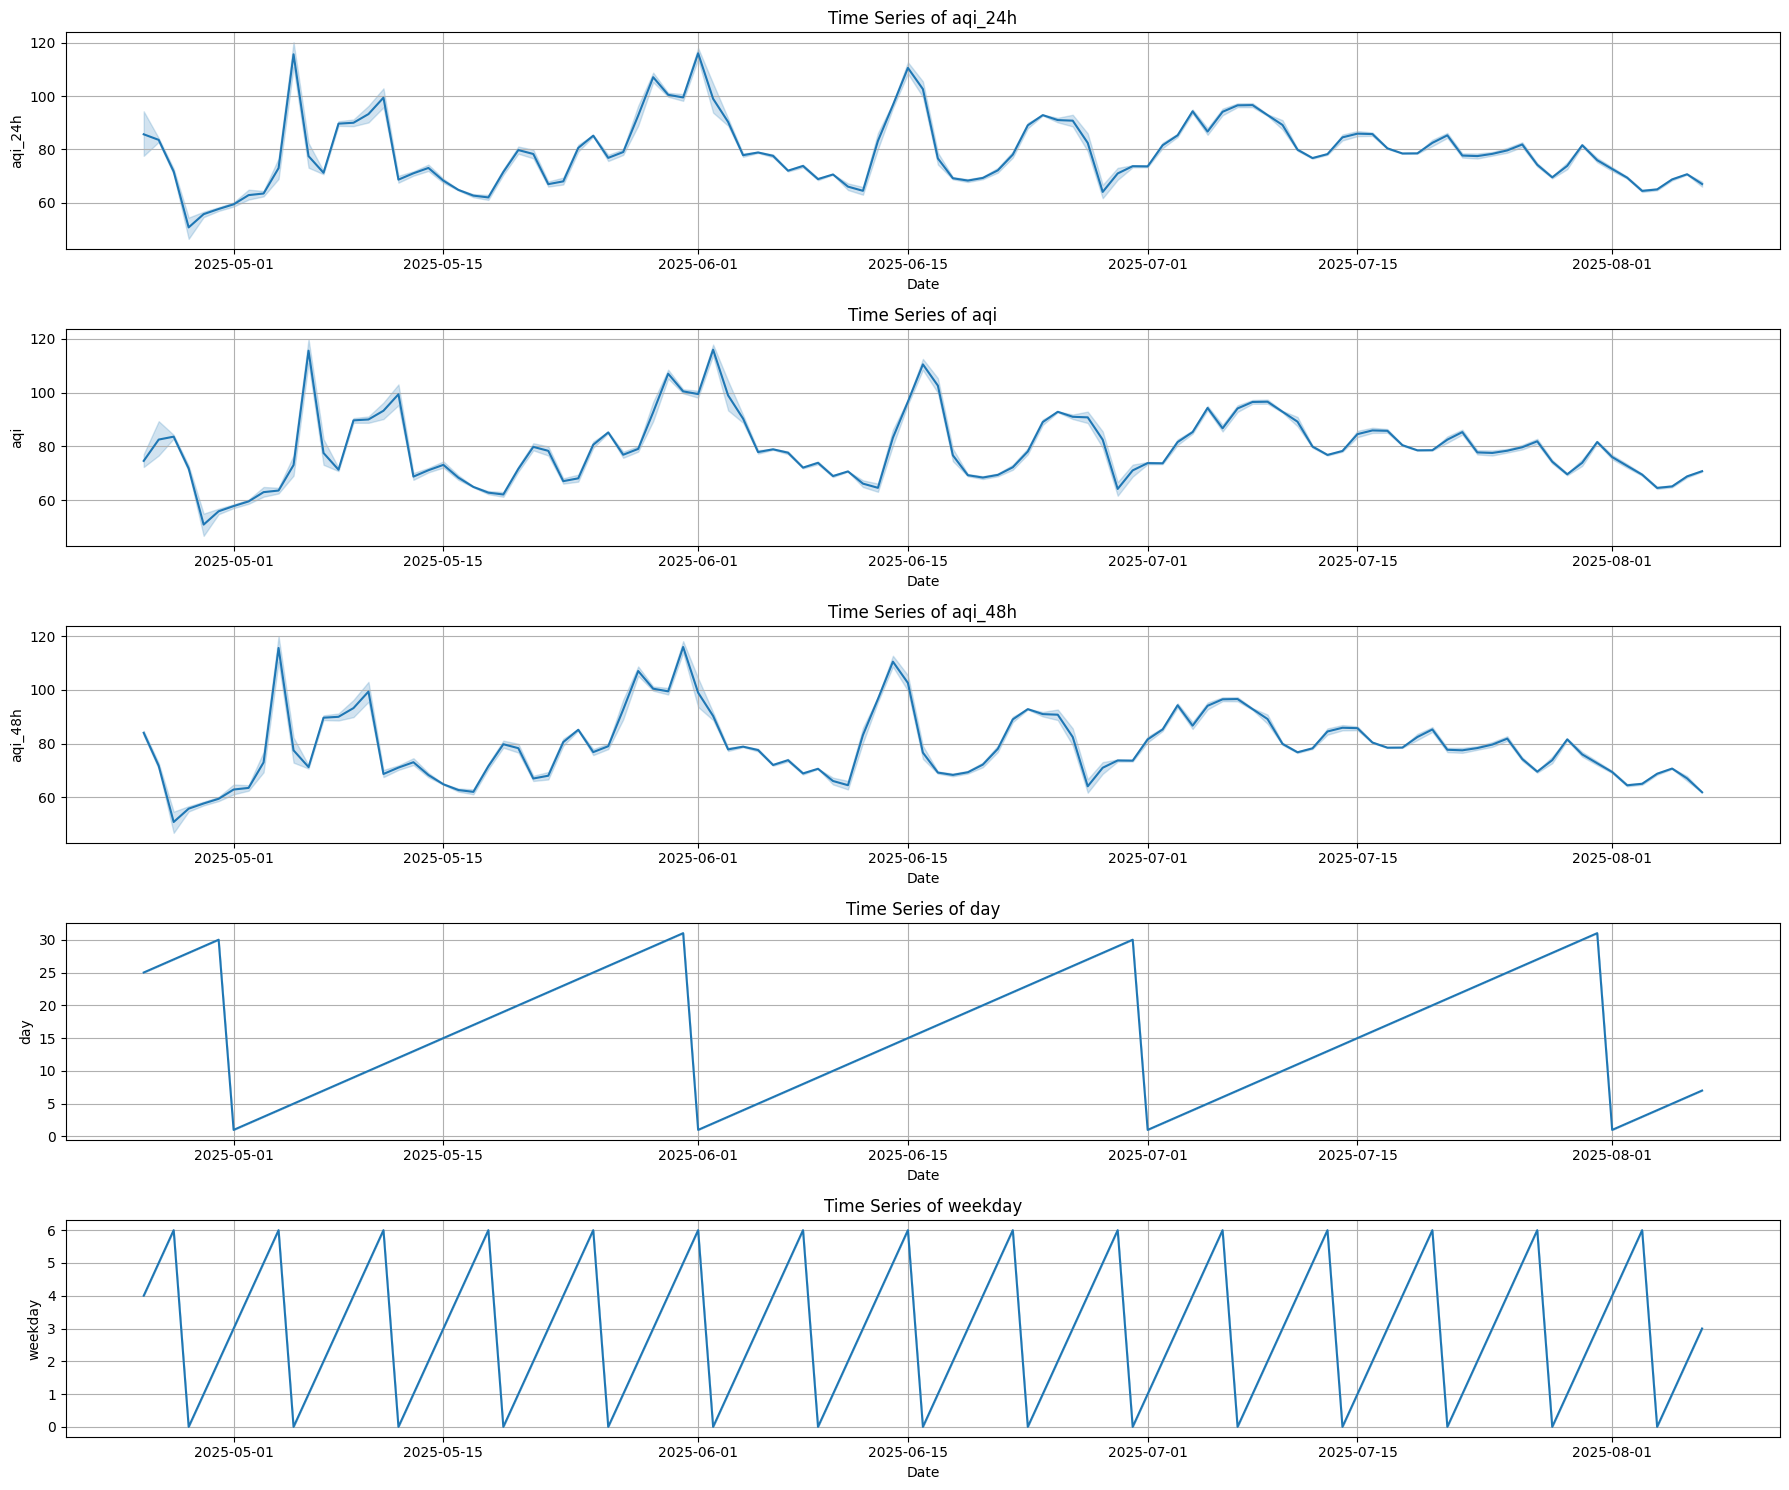

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'final_features_df_24h' in locals():
    plot_df = final_features_df_24h.copy()
    target_column_24h = forecasting_system_24h.target_column

    selected_features_24h = forecasting_system_24h.selected_features

    if target_column_24h not in plot_df.columns:
        print(f"Error: Target column '{target_column_24h}' not found in the dataframe.")
    else:
        features_to_plot = []
        if hasattr(forecasting_system_24h, 'deployment_models') and forecasting_system_24h.deployment_models:
            importance_results = forecasting_system_24h.get_feature_importance(top_k=10)
            if importance_results:
                model_with_imp = None
                for model_name in ['XGBoost', 'CatBoost', 'RandomForest']:
                    if model_name in importance_results and importance_results[model_name]:
                        model_with_imp = model_name
                        break

                if model_with_imp:
                    top_features_with_imp = [feat for feat, imp in importance_results[model_with_imp]]

                    features_to_plot = [feat for feat in top_features_with_imp if feat in selected_features_24h][:4]
                    print(f"Plotting top features based on {model_with_imp} importance.")
                else:

                    features_to_plot = selected_features_24h[:4]
                    print("Could not get model importance. Plotting top features from selected list.")
            else:
                features_to_plot = selected_features_24h[:4]
                print("No model importance results found. Plotting top features from selected list.")
        else:
             features_to_plot = selected_features_24h[:4]
             print("Deployment models not available. Plotting top features from selected list.")

        plot_columns = [target_column_24h] + features_to_plot
        plot_columns = [col for col in plot_columns if col in plot_df.columns]


        if not plot_columns:
            print("No valid columns to plot.")
        else:
            plt.figure(figsize=(18, len(plot_columns) * 3))

            for i, col in enumerate(plot_columns):
                plt.subplot(len(plot_columns), 1, i + 1)
                sns.lineplot(data=plot_df, x=plot_df.index, y=col)
                plt.title(f'Time Series of {col}')
                plt.ylabel(col)
                plt.xlabel('Date')
                plt.grid(True)

            plt.tight_layout()
            plt.show()

else:
    print("Processed dataframe 'final_features_df_24h' not found. Please run the preprocessing step first.")

In [14]:
preprocessor_48h = AQIDataPreprocessor(dataframe=existing_df)

success_48h = preprocessor_48h.run_full_preprocessing(
    correlation_threshold=0.85,
    variance_threshold=1e-6,
    vif_threshold=8,
    dataframe=existing_df,
    forecast_horizon=48,
)

if success_48h:
    processed_data_48h = preprocessor_48h.get_processed_data()

    if processed_data_48h and 'full_data' in processed_data_48h:
        final_features_df_48h = processed_data_48h['full_data']
        print("\nProcessed data for 48h forecast assigned to final_features_df_48h.")
        print(f"Shape of 48h features: {final_features_df_48h.shape}")

if 'final_features_df_48h' in locals():
    forecasting_system_48h = AQIForecastingSystem(
        horizon_df=final_features_df_48h,
        target_column='aqi_48h',
        horizon_hours=48,
        model_save_path="./my_aqi_models_48h"
    )

    results_48h = forecasting_system_48h.run_complete_pipeline(
        max_features=15
    )

    print("\n\nCompleted the full pipeline for the 48-hour forecast!")
else:
    print("Please run the previous cell to generate the 48-hour features first.")

STARTING FULL PREPROCESSING PIPELINE

LOADING DATA
Using provided DataFrame.

DATA INSPECTION
Dataset shape: (2700, 16)
Memory usage: 0.33 MB

Column data types:
temperature       float64
humidity          float64
wind_speed        float64
wind_direction    float64
hour              float64
day               float64
weekday           float64
pm2_5             float64
pm10              float64
co                float64
so2               float64
o3                float64
no2               float64
aqi               float64
date               object
date_str           object
dtype: object

Missing values:
Series([], dtype: int64)

Basic statistics:
       temperature     humidity   wind_speed  wind_direction         hour  \
count  2700.000000  2700.000000  2700.000000     2700.000000  2700.000000   
mean     29.745574    73.588401    47.278501      238.983551    11.526667   
std       3.464100    14.321789    15.501349       39.579465     6.923417   
min       0.000000     0.000000     0.0

In [15]:
preprocessor_72h = AQIDataPreprocessor(dataframe=existing_df)

success_72h = preprocessor_72h.run_full_preprocessing(
    correlation_threshold=0.85,
    variance_threshold=1e-6,
    vif_threshold=8,
    dataframe=existing_df,
    forecast_horizon=72,
)

if success_72h:
    processed_data_72h = preprocessor_72h.get_processed_data()

    if processed_data_72h and 'full_data' in processed_data_72h:
        final_features_df_72h = processed_data_72h['full_data']
        print("\nProcessed data for 72h forecast assigned to final_features_df_72h.")
        print(f"Shape of 72h features: {final_features_df_72h.shape}")

if 'final_features_df_72h' in locals():
    forecasting_system_72h = AQIForecastingSystem(
        horizon_df=final_features_df_72h,
        target_column='aqi_72h',
        horizon_hours=72,
        model_save_path="./my_aqi_models_72h"
    )

    results_72h = forecasting_system_72h.run_complete_pipeline(
        max_features=8
    )

    print("\n\nCompleted the full pipeline for the 72-hour forecast!")
else:
    print("Please run the previous cell to generate the 72-hour features first.")

STARTING FULL PREPROCESSING PIPELINE

LOADING DATA
Using provided DataFrame.

DATA INSPECTION
Dataset shape: (2700, 16)
Memory usage: 0.33 MB

Column data types:
temperature       float64
humidity          float64
wind_speed        float64
wind_direction    float64
hour              float64
day               float64
weekday           float64
pm2_5             float64
pm10              float64
co                float64
so2               float64
o3                float64
no2               float64
aqi               float64
date               object
date_str           object
dtype: object

Missing values:
Series([], dtype: int64)

Basic statistics:
       temperature     humidity   wind_speed  wind_direction         hour  \
count  2700.000000  2700.000000  2700.000000     2700.000000  2700.000000   
mean     29.745574    73.588401    47.278501      238.983551    11.526667   
std       3.464100    14.321789    15.501349       39.579465     6.923417   
min       0.000000     0.000000     0.0


--- Generating Correlation Heatmap for 24h Horizon ---
Generating correlation heatmap for 11 features (selected features + target)...


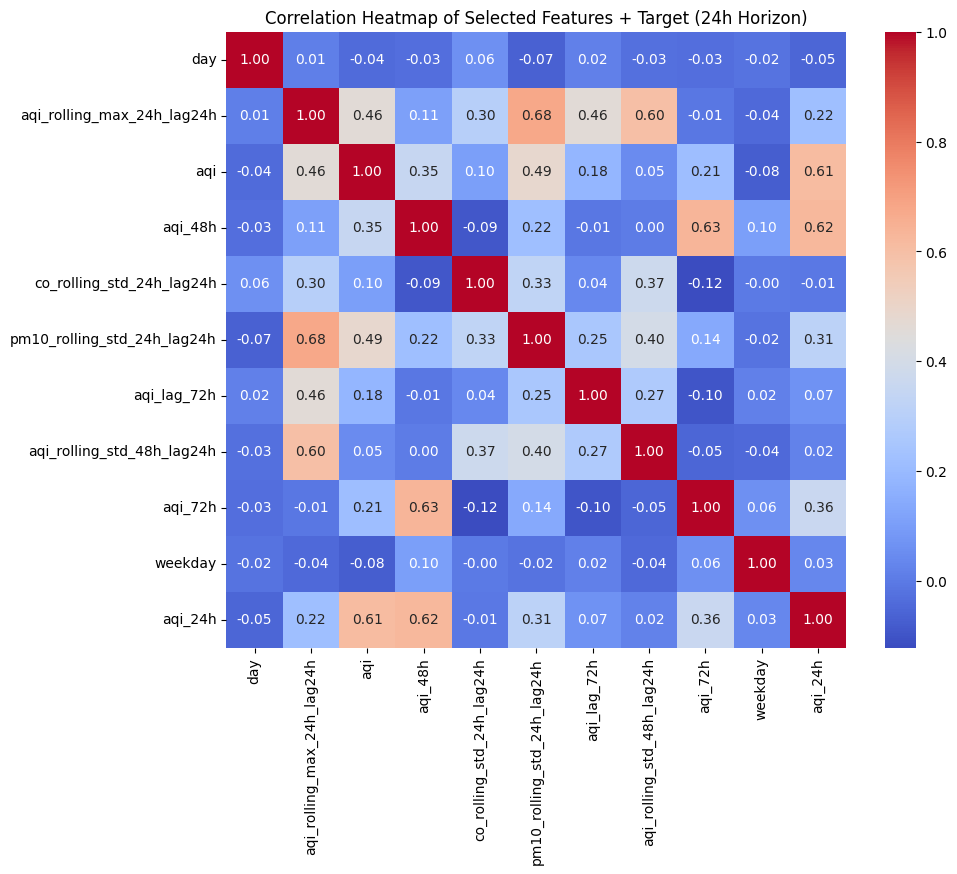


--- Generating Correlation Heatmap for 48h Horizon ---
Generating correlation heatmap for 16 features (selected features + target)...


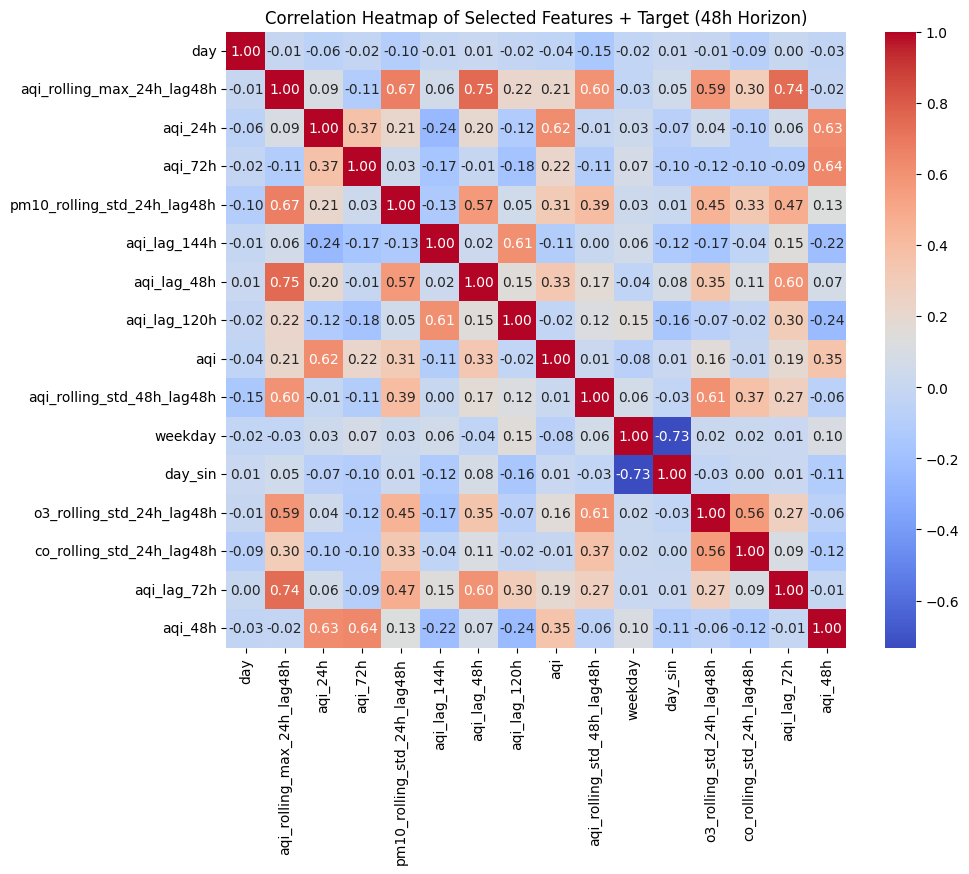


--- Generating Correlation Heatmap for 72h Horizon ---
Generating correlation heatmap for 9 features (selected features + target)...


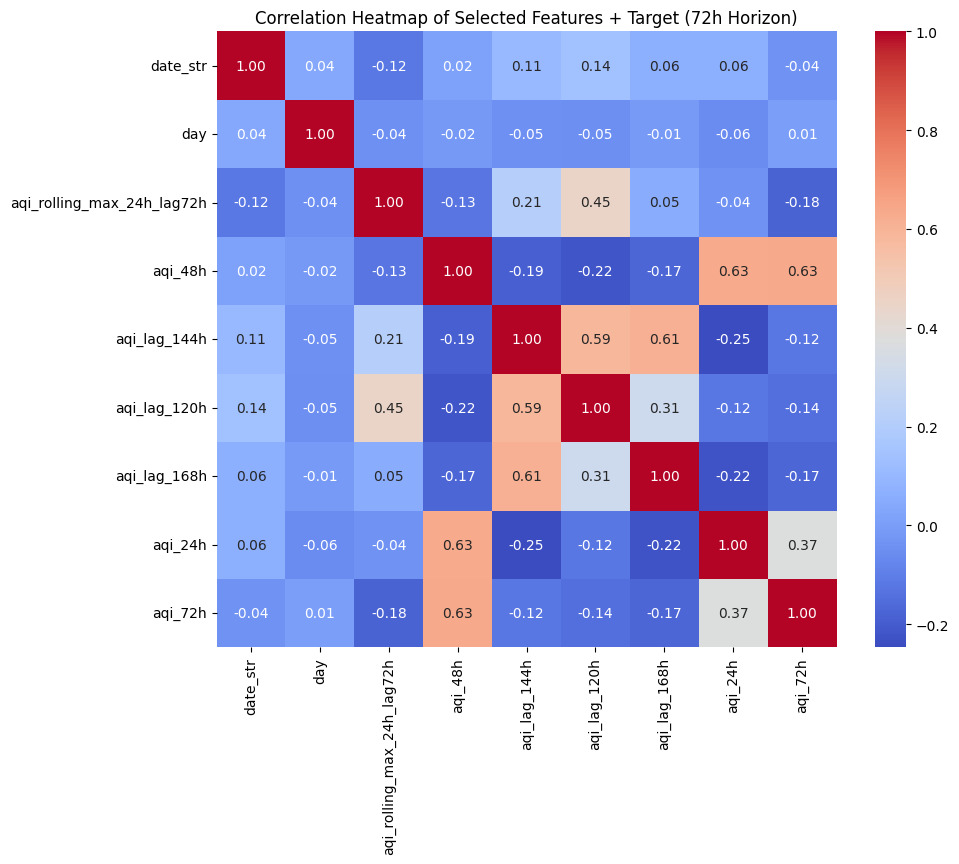

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

horizons = [24, 48, 72]
horizon_data = {
    24: {'df': final_features_df_24h, 'system': forecasting_system_24h},
    48: {'df': final_features_df_48h, 'system': forecasting_system_48h},
    72: {'df': final_features_df_72h, 'system': forecasting_system_72h},
}

for horizon in horizons:
    print(f"\n--- Generating Correlation Heatmap for {horizon}h Horizon ---")
    if horizon in horizon_data and horizon_data[horizon]['df'] is not None and horizon_data[horizon]['system'] is not None:
        plot_df = horizon_data[horizon]['df'].copy()
        forecasting_system = horizon_data[horizon]['system']
        selected_features = forecasting_system.selected_features
        target_column = forecasting_system.target_column

        features_to_plot_corr = selected_features.copy()
        if target_column in plot_df.columns and target_column not in features_to_plot_corr:
            features_to_plot_corr.append(target_column)

        plot_corr_df = plot_df[features_to_plot_corr].copy()

        numeric_plot_corr_df = plot_corr_df.select_dtypes(include=np.number)


        if not numeric_plot_corr_df.empty:
            print(f"Generating correlation heatmap for {len(numeric_plot_corr_df.columns)} features (selected features + target)...")
            plt.figure(figsize=(10, 8))
            sns.heatmap(numeric_plot_corr_df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
            plt.title(f'Correlation Heatmap of Selected Features + Target ({horizon}h Horizon)')
            plt.show()
        else:
            print(f"No numeric features found in the selected features for {horizon}h horizon to plot correlation.")

    else:
        print(f"Processed dataframe or forecasting system object not found for {horizon}h horizon.")


--- Generating SHAP Analysis for 24h Horizon using ExtraTrees ---
Using ExtraTrees for SHAP analysis for 24h horizon.
Prepared data for SHAP with shape: (2508, 10)
Using a subset of data (1000 samples) for faster SHAP calculation.
Calculating SHAP values (this might take some time)...
SHAP values calculation complete.

Generating SHAP summary plot (Overall Feature Importance)...


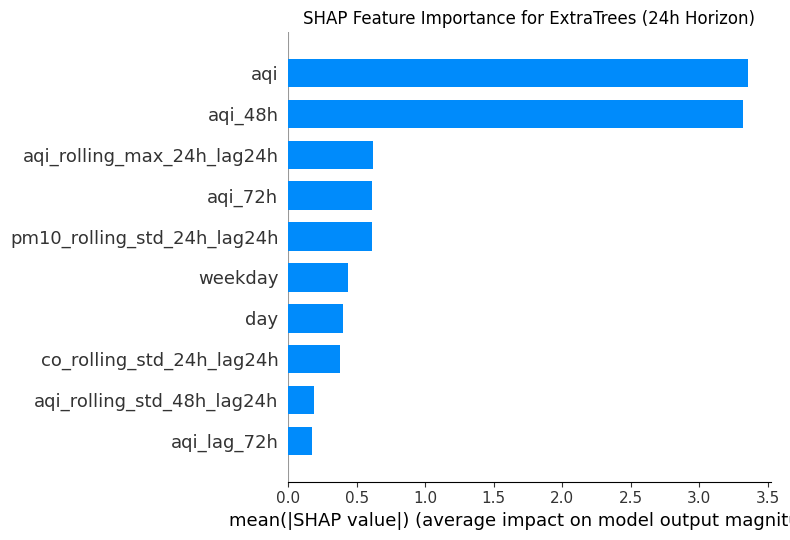


Generating SHAP summary plot (Feature Impact and Direction)...


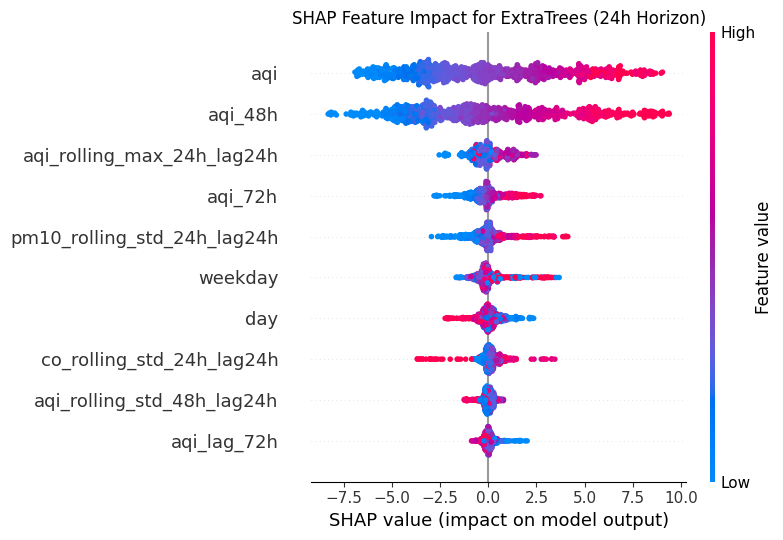


Generating SHAP dependence plot for: aqi


<Figure size 800x600 with 0 Axes>

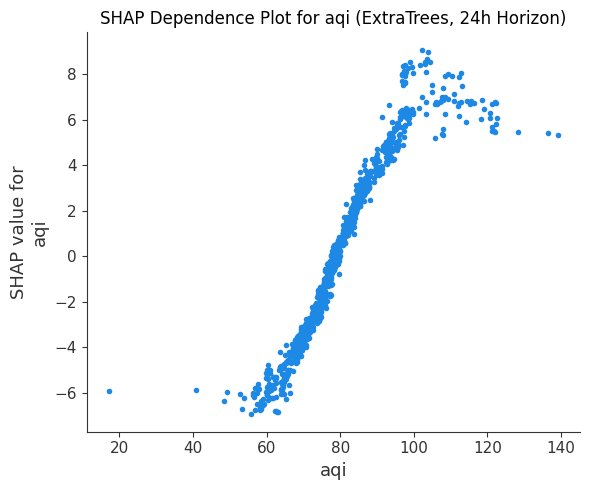


--- Generating SHAP Analysis for 48h Horizon using ExtraTrees ---
Using ExtraTrees for SHAP analysis for 48h horizon.
Prepared data for SHAP with shape: (2484, 15)
Using a subset of data (1000 samples) for faster SHAP calculation.
Calculating SHAP values (this might take some time)...
SHAP values calculation complete.

Generating SHAP summary plot (Overall Feature Importance)...


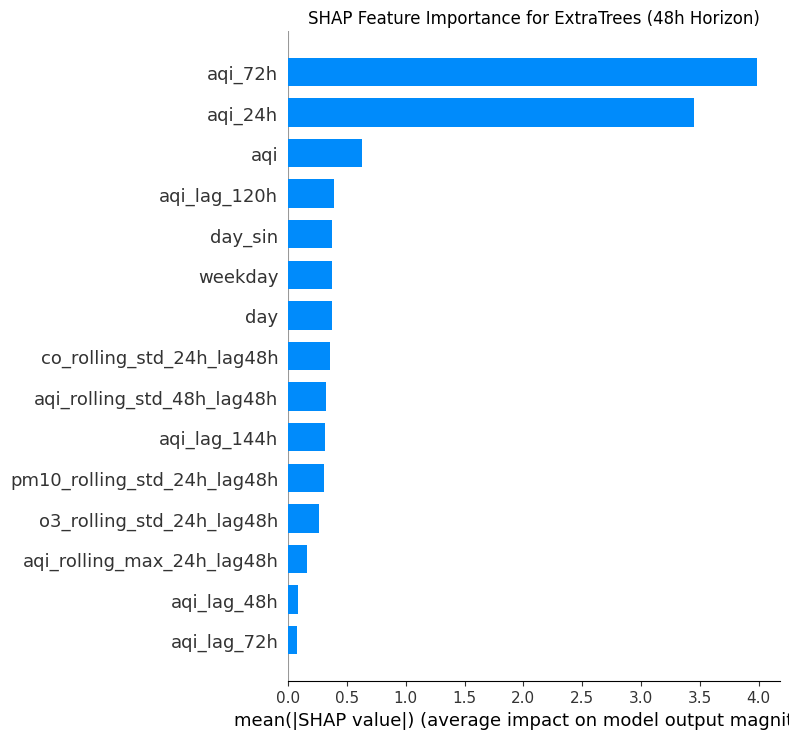


Generating SHAP summary plot (Feature Impact and Direction)...


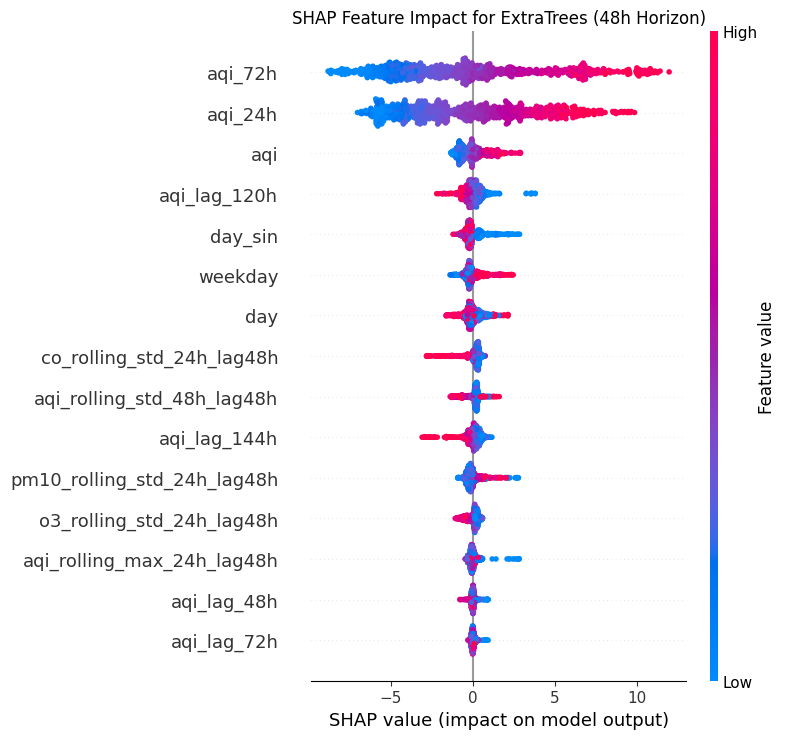


Generating SHAP dependence plot for: aqi_72h


<Figure size 800x600 with 0 Axes>

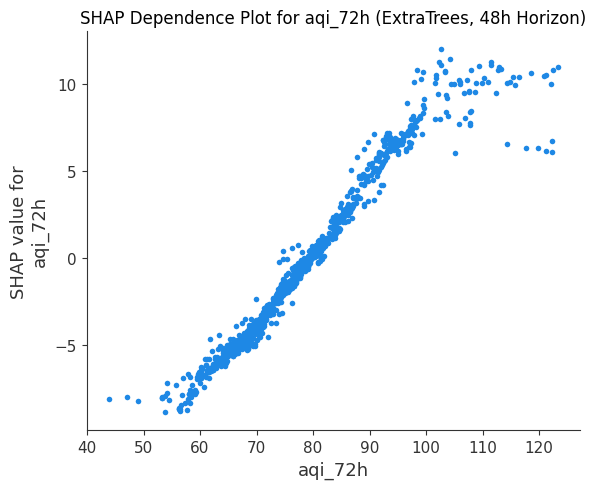


--- Generating SHAP Analysis for 72h Horizon using ExtraTrees ---
Using ExtraTrees for SHAP analysis for 72h horizon.
Prepared data for SHAP with shape: (2460, 8)
Using a subset of data (1000 samples) for faster SHAP calculation.
Calculating SHAP values (this might take some time)...
SHAP values calculation complete.

Generating SHAP summary plot (Overall Feature Importance)...


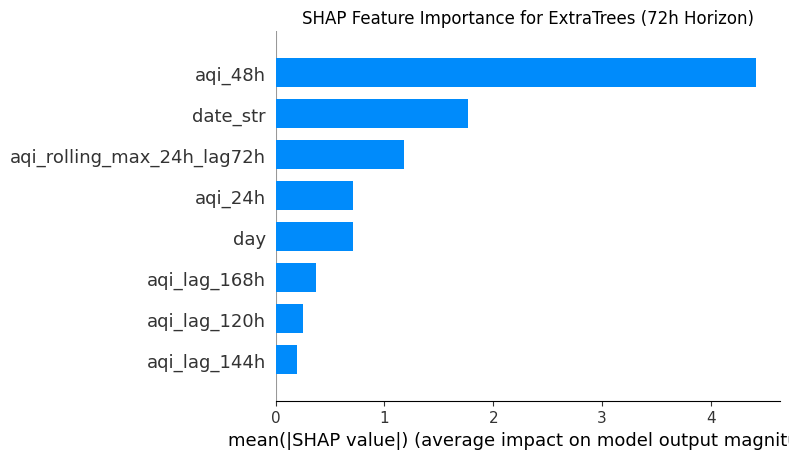


Generating SHAP summary plot (Feature Impact and Direction)...


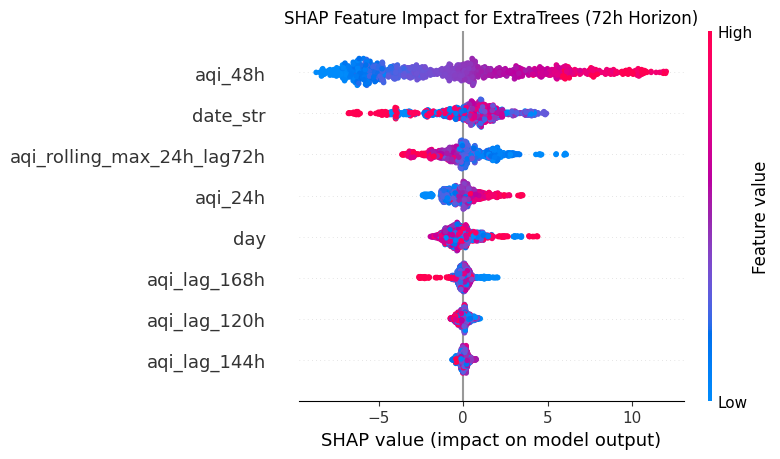


Generating SHAP dependence plot for: aqi_48h


<Figure size 800x600 with 0 Axes>

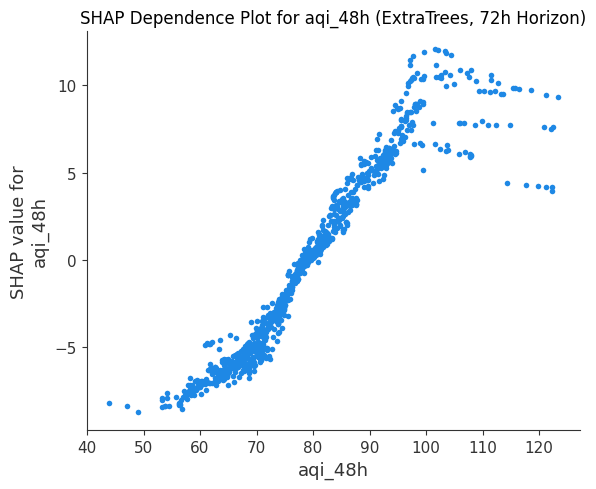

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

shap.initjs()

horizons_info = {
    24: {'system': forecasting_system_24h, 'best_model_name': 'ExtraTrees'},
    48: {'system': forecasting_system_48h, 'best_model_name': 'ExtraTrees'},
    72: {'system': forecasting_system_72h, 'best_model_name': 'ExtraTrees'},
}

for horizon, info in horizons_info.items():
    forecasting_system = info['system']
    model_name = info['best_model_name']

    print(f"\n--- Generating SHAP Analysis for {horizon}h Horizon using {model_name} ---")

    if forecasting_system is not None and hasattr(forecasting_system, 'deployment_models'):
        if model_name in forecasting_system.deployment_models and forecasting_system.deployment_models[model_name] is not None:
            model = forecasting_system.deployment_models[model_name]
            print(f"Using {model_name} for SHAP analysis for {horizon}h horizon.")

            if hasattr(forecasting_system, 'df') and not forecasting_system.df.empty:
                full_data = forecasting_system.df.copy()
                selected_features = forecasting_system.selected_features

                if hasattr(forecasting_system, 'deployment_models') and forecasting_system.deployment_models[model_name] is not None:
                    valid_features = [f for f in selected_features if f in full_data.columns]
                    if forecasting_system.target_column in full_data.columns:
                        all_cols = valid_features + [forecasting_system.target_column]
                    else:
                        all_cols = valid_features

                    clean_data = full_data[all_cols].copy()
                    clean_data = clean_data.fillna(method='ffill').fillna(method='bfill')
                    for col in clean_data.columns:
                        if clean_data[col].isna().any():
                            clean_data[col].fillna(clean_data[col].median(), inplace=True)


                    X_shap = clean_data[valid_features]

                    if X_shap.empty:
                        print("Prepared data for SHAP is empty.")
                    else:
                        print(f"Prepared data for SHAP with shape: {X_shap.shape}")
                        if X_shap.shape[0] > 1000:
                             print("Using a subset of data (1000 samples) for faster SHAP calculation.")
                             X_shap_subset = shap.utils.sample(X_shap, 1000)
                        else:
                             X_shap_subset = X_shap

                        try:
                            explainer = shap.TreeExplainer(model)

                            print("Calculating SHAP values (this might take some time)...")
                            shap_values = explainer.shap_values(X_shap_subset)
                            print("SHAP values calculation complete.")

                            print("\nGenerating SHAP summary plot (Overall Feature Importance)...")
                            plt.figure(figsize=(10, 6))
                            shap.summary_plot(shap_values, X_shap_subset, plot_type="bar", show=False)
                            plt.title(f"SHAP Feature Importance for {model_name} ({horizon}h Horizon)")
                            plt.tight_layout()
                            plt.show()

                            print("\nGenerating SHAP summary plot (Feature Impact and Direction)...")
                            plt.figure(figsize=(10, 8))
                            shap.summary_plot(shap_values, X_shap_subset, show=False)
                            plt.title(f"SHAP Feature Impact for {model_name} ({horizon}h Horizon)")
                            plt.tight_layout()
                            plt.show()
                            if selected_features:
                                mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
                                top_feature_index = np.argmax(mean_abs_shap_values)
                                feature_to_plot = X_shap_subset.columns[top_feature_index]


                                print(f"\nGenerating SHAP dependence plot for: {feature_to_plot}")
                                try:
                                    plt.figure(figsize=(8, 6))
                                    shap.dependence_plot(feature_to_plot, shap_values, X_shap_subset, interaction_index=None, show=False)
                                    plt.title(f"SHAP Dependence Plot for {feature_to_plot} ({model_name}, {horizon}h Horizon)")
                                    plt.tight_layout()
                                    plt.show()
                                except Exception as e:
                                    print(f"Could not generate dependence plot for {feature_to_plot}: {e}")
                            else:
                                 print("No selected features to plot dependence.")


                        except Exception as e:
                            print(f"Error creating SHAP explainer or calculating values: {e}")

                else:
                     print("Could not prepare data for SHAP analysis.")
            else:
                print("Full dataset not found in forecasting system object.")
        else:
            print(f"Trained model '{model_name}' not found in deployment_models for {horizon}h horizon.")
    else:
        print(f"Forecasting system object or deployment_models not found for {horizon}h horizon. Please run the pipeline first.")

In [18]:
!pip install tensorflow

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def create_sequences(data, labels, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(labels.iloc[i + time_steps])
    return np.array(X), np.array(y)

horizons = [24, 48, 72]
horizon_results = {}
trained_models = {}

for horizon in horizons:
    print(f"\n{'='*50}")
    print(f"TRAINING DEEP LEARNING MODEL FOR {horizon}H HORIZON")
    print(f"{'='*50}")

    processed_df = None
    target_column = None

    if horizon == 24 and 'final_features_df_24h' in locals():
        processed_df = final_features_df_24h.copy()
        target_column = 'aqi_24h'
    elif horizon == 48 and 'final_features_df_48h' in locals():
        processed_df = final_features_df_48h.copy()
        target_column = 'aqi_48h'
    elif horizon == 72 and 'final_features_df_72h' in locals():
        processed_df = final_features_df_72h.copy()
        target_column = 'aqi_72h'

    if processed_df is not None and target_column in processed_df.columns:
        print(f"Using {horizon}h horizon data for DL model experiment.")

        X = processed_df.drop(columns=[col for col in processed_df.columns if 'aqi_' in col] + ['aqi'], errors='ignore')
        y = processed_df[target_column]

        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X.dropna(axis=1, inplace=True)

        combined_df = pd.concat([X, y], axis=1).dropna()
        X = combined_df.drop(columns=[target_column])
        y = combined_df[target_column]

        if X.empty or y.empty:
            print(f"Data is empty after cleaning for {horizon}h horizon DL. Cannot train model.")
            horizon_results[horizon] = "Training Failed - Empty Data"
            continue
        else:
            print(f"Data prepared for DL: X shape {X.shape}, y shape {y.shape}")

            scaler_X = MinMaxScaler()
            X_scaled = scaler_X.fit_transform(X)

            scaler_y = MinMaxScaler()
            y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

            X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
            y_scaled_s = pd.Series(y_scaled.flatten(), index=y.index)
            time_steps = 72

            if len(X_scaled_df) > time_steps:
                X_sequences, y_sequences = create_sequences(X_scaled_df, y_scaled_s, time_steps)
            else:
                print(f"Not enough data ({len(X_scaled_df)} samples) to create sequences with time_steps={time_steps} for {horizon}h horizon. Reduce time_steps or provide more data.")
                horizon_results[horizon] = f"Training Failed - Insufficient Data for Sequences (time_steps={time_steps})"
                continue


            if X_sequences.shape[0] == 0:
                 print(f"Not enough data to create sequences with time_steps={time_steps} for {horizon}h horizon. Reduce time_steps or provide more data.")
                 horizon_results[horizon] = f"Training Failed - Empty Sequences (time_steps={time_steps})"
                 continue
            else:
                print(f"Sequences created: X_sequences shape {X_sequences.shape}, y_sequences shape {y_sequences.shape}")

                split_index = int(len(X_sequences) * 0.8)
                X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
                y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]


                print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

                model = Sequential()
                model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[2])))
                model.add(Dropout(0.2))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')

                print("\nTraining the DL model...")
                history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, shuffle=False)
                print("DL model training complete.")

                loss = model.evaluate(X_test, y_test, verbose=0)
                print(f'Test Loss (MSE): {loss:.4f}')

                y_pred_scaled = model.predict(X_test)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

                test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
                test_mae = mean_absolute_error(y_test_actual, y_pred)

                print(f'Test RMSE: {test_rmse:.4f}')
                print(f'Test MAE: {test_mae:.4f}')

                horizon_results[horizon] = {
                    'test_loss': loss,
                    'test_rmse': test_rmse,
                    'test_mae': test_mae,
                    'history': history.history,
                    'y_test_actual': y_test_actual,
                    'y_pred': y_pred,
                    'test_indices': combined_df.iloc[len(X_sequences) + time_steps - len(y_test_actual) : len(X_sequences) + time_steps].index,
                    'scaler_y': scaler_y,
                    'scaler_X': scaler_X,
                    'feature_names': X.columns.tolist(),
                    'time_steps': time_steps,
                    'X_test': X_test
                }
                trained_models[horizon] = model


    else:
        print(f"Processed dataframe or target column '{target_column}' not found for {horizon}h horizon.")
        horizon_results[horizon] = "Training Skipped - Data Not Found"

for horizon in horizons:
    print(f"\n{'='*50}")
    print(f"MAKING PREDICTIONS FOR {horizon}H HORIZON")
    print(f"{'='*50}")

    if horizon in trained_models and horizon in horizon_results:
        model = trained_models[horizon]
        results = horizon_results[horizon]

        if isinstance(results, str) and "Training Failed" in results:
            print(f"Skipping predictions for {horizon}h horizon due to previous training failure: {results}")
            continue

        X_test_sequences = results.get('X_test')
        y_test_actual = results.get('y_test_actual')
        scaler_X = results.get('scaler_X')
        scaler_y = results.get('scaler_y')
        feature_names = results.get('feature_names')
        time_steps = results.get('time_steps')
        test_indices = results.get('test_indices')

        if X_test_sequences is None or y_test_actual is None:
             print(f"Required data for prediction not found in results for {horizon}h horizon.")
             continue

        subset_size = min(100, X_test_sequences.shape[0])
        if subset_size == 0:
            print(f"Test data for {horizon}h horizon is empty. Cannot make predictions.")
            continue

        X_new_sequences = X_test_sequences[-subset_size:]
        y_new_actual = y_test_actual[-subset_size:]
        new_data_indices = test_indices[-subset_size:]


        print(f"Making predictions on the last {subset_size} samples of the test set.")

        y_new_pred_scaled = model.predict(X_new_sequences)

        y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

        horizon_results[horizon]['y_new_actual'] = y_new_actual
        horizon_results[horizon]['y_new_pred'] = y_new_pred
        horizon_results[horizon]['new_data_indices'] = new_data_indices

        print(f"Predictions made for {horizon}h horizon. Stored {len(y_new_pred)} predictions.")

    else:
        print(f"Trained model or results not found for {horizon}h horizon. Skipping predictions.")



TRAINING DEEP LEARNING MODEL FOR 24H HORIZON
Using 24h horizon data for DL model experiment.
Data prepared for DL: X shape (2508, 55), y shape (2508,)
Sequences created: X_sequences shape (2436, 72, 55), y_sequences shape (2436,)
Training data shape: (1948, 72, 55), Testing data shape: (488, 72, 55)

Training the DL model...
DL model training complete.
Test Loss (MSE): 0.0050
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test RMSE: 8.6635
Test MAE: 6.8959

TRAINING DEEP LEARNING MODEL FOR 48H HORIZON
Using 48h horizon data for DL model experiment.
Data prepared for DL: X shape (2484, 55), y shape (2484,)
Sequences created: X_sequences shape (2412, 72, 55), y_sequences shape (2412,)
Training data shape: (1929, 72, 55), Testing data shape: (483, 72, 55)

Training the DL model...
DL model training complete.
Test Loss (MSE): 0.0257
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test RMSE: 19.5421
Test MAE: 15.0504

TRAINING DEEP LEARNING MODEL FOR 72H HORIZON
Using 72h horizon data for DL model experi


PERFORMANCE REPORT FOR 24H HORIZON (DEEP LEARNING MODEL)
Test Set Metrics:
  Test Loss (MSE): 0.0050
  Test RMSE: 8.6635
  Test MAE: 6.8959
  Time Steps used: 72
  Number of Features: 55
  Selected Features: ['temperature', 'humidity', 'wind_speed', 'wind_direction', 'day']...


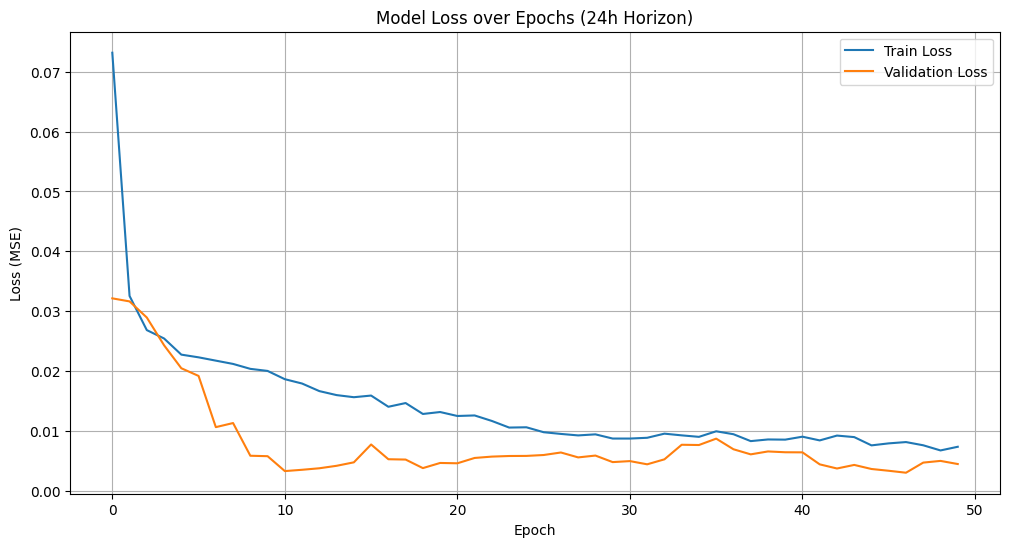

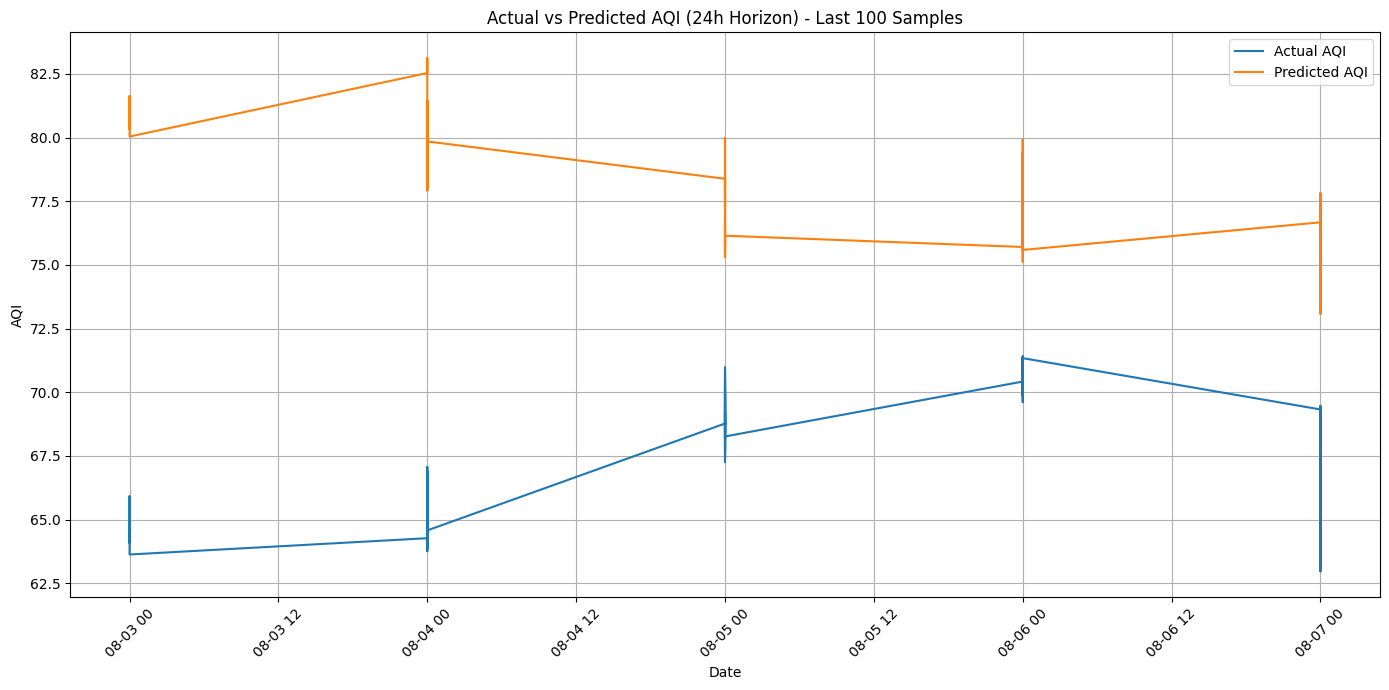


PERFORMANCE REPORT FOR 48H HORIZON (DEEP LEARNING MODEL)
Test Set Metrics:
  Test Loss (MSE): 0.0257
  Test RMSE: 19.5421
  Test MAE: 15.0504
  Time Steps used: 72
  Number of Features: 55
  Selected Features: ['temperature', 'humidity', 'wind_speed', 'wind_direction', 'day']...


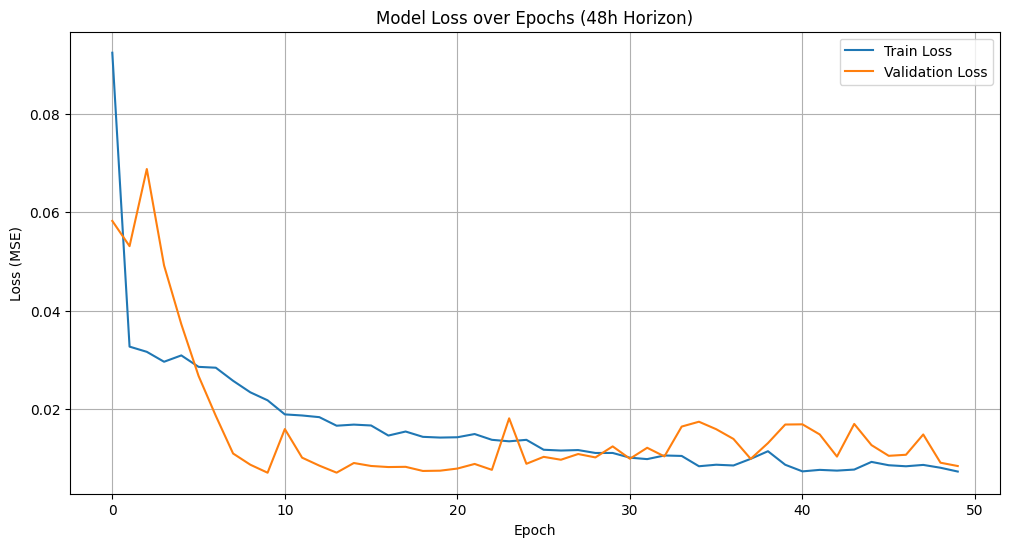

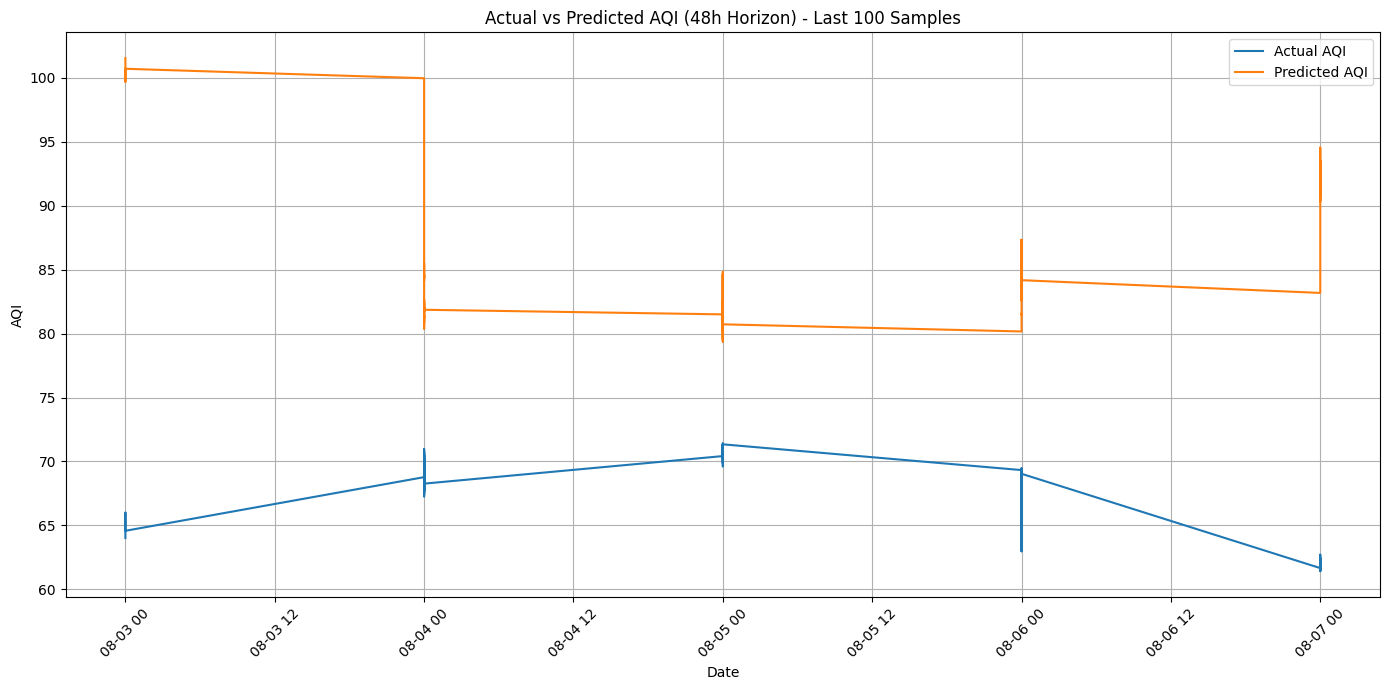


PERFORMANCE REPORT FOR 72H HORIZON (DEEP LEARNING MODEL)
Test Set Metrics:
  Test Loss (MSE): 0.0301
  Test RMSE: 15.6260
  Test MAE: 12.3746
  Time Steps used: 72
  Number of Features: 55
  Selected Features: ['temperature', 'humidity', 'wind_speed', 'wind_direction', 'day']...


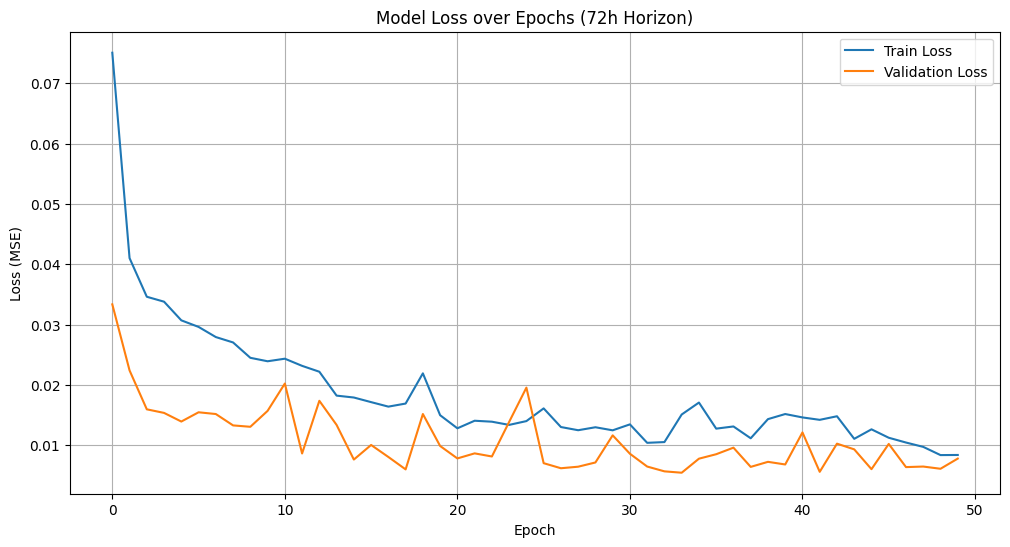

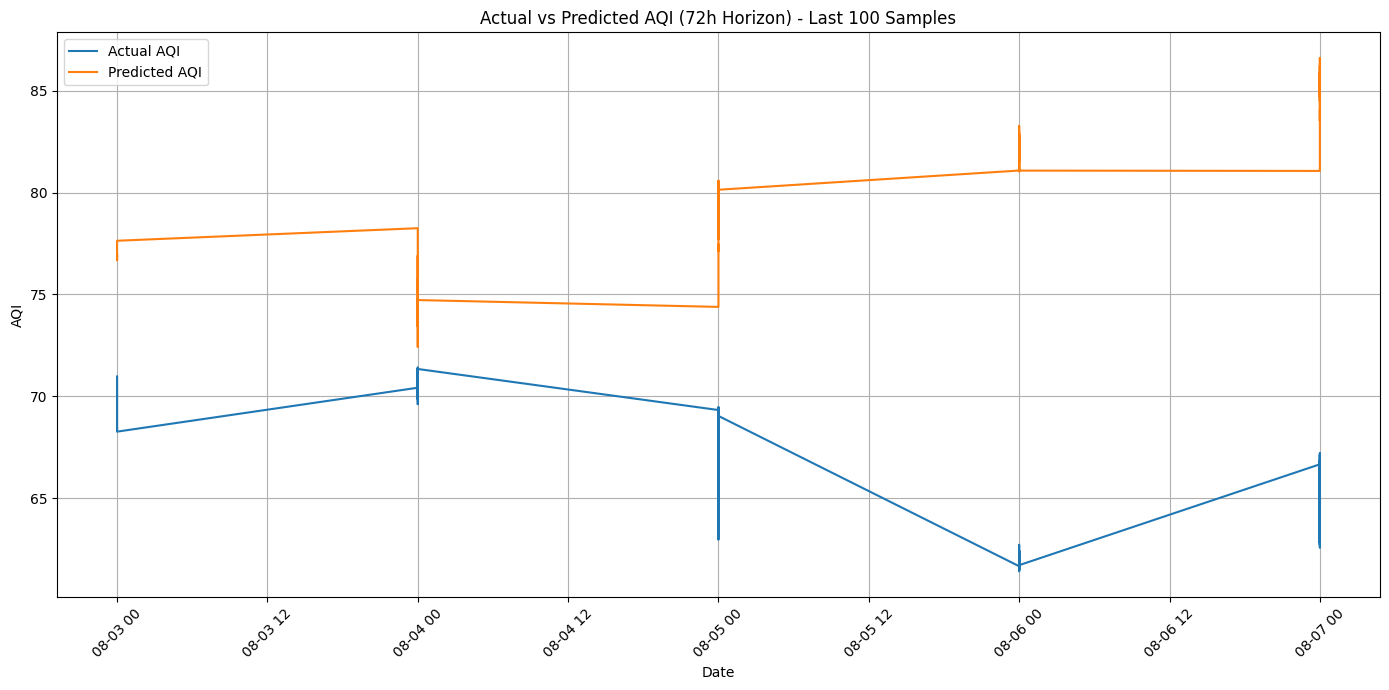

In [21]:
for horizon in horizons:
    print(f"\n{'='*50}")
    print(f"PERFORMANCE REPORT FOR {horizon}H HORIZON (DEEP LEARNING MODEL)")
    print(f"{'='*50}")

    if horizon in horizon_results:
        results = horizon_results[horizon]

        if isinstance(results, str) and "Training Failed" in results:
            print(f"No results available due to: {results}")
            continue

        print(f"Test Set Metrics:")
        print(f"  Test Loss (MSE): {results['test_loss']:.4f}")
        print(f"  Test RMSE: {results['test_rmse']:.4f}")
        print(f"  Test MAE: {results['test_mae']:.4f}")
        print(f"  Time Steps used: {results['time_steps']}")
        print(f"  Number of Features: {len(results['feature_names'])}")
        print(f"  Selected Features: {results['feature_names'][:5]}{'...' if len(results['feature_names']) > 5 else ''}")


        if 'history' in results:
            plt.figure(figsize=(12, 6))
            plt.plot(results['history']['loss'], label='Train Loss')
            plt.plot(results['history']['val_loss'], label='Validation Loss')
            plt.title(f'Model Loss over Epochs ({horizon}h Horizon)')
            plt.ylabel('Loss (MSE)')
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()
        if 'y_new_actual' in results and 'y_new_pred' in results and 'new_data_indices' in results:
            plt.figure(figsize=(14, 7))
            plt.plot(results['new_data_indices'], results['y_new_actual'], label='Actual AQI')
            plt.plot(results['new_data_indices'], results['y_new_pred'], label='Predicted AQI')
            plt.title(f'Actual vs Predicted AQI ({horizon}h Horizon) - Last 100 Samples')
            plt.xlabel('Date')
            plt.ylabel('AQI')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("Prediction data (y_new_actual, y_new_pred, or new_data_indices) not found in results.")


    else:
        print(f"Results not found for {horizon}h horizon.")